# LAB: Multimodal Learning WSI + Genomics
Authors:
- Vittorio Pipoli (vittorio.pipoli@unimore.it)
- Francesca Miccolis (francesca.miccolis@unimore.it)

### Assignment Goals
1. Familiarity with the “Survival Prediction from WSI and Genomics” task
2. Familiarity with multimodal architectures
3. Implementation of a customised model for “Survival Prediction from WSI and Genomics”

### References
1. ABMIL (paper: https://proceedings.mlr.press/v80/ilse18a/ilse18a.pdf)
3. MCAT (paper: https://openaccess.thecvf.com/content/ICCV2021/papers/Chen_Multimodal_Co-Attention_Transformer_for_Survival_Prediction_in_Gigapixel_Whole_Slide_ICCV_2021_paper.pdf)
2. SurvPath (paper: https://openaccess.thecvf.com/content/CVPR2024/papers/Jaume_Modeling_Dense_Multimodal_Interactions_Between_Biological_Pathways_and_Histology_for_CVPR_2024_paper.pdf)

### install missing packages

In [245]:
!pip install pytorch_model_summary
!pip install munch
!pip install scikit-survival
!pip install lifelines

### import packages

In [246]:
import os
import torch
from torch import nn
import torch.optim as optim
from torch.backends import cudnn
import torch.nn.init as init
from pytorch_model_summary import summary
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
import time
import logging
from tqdm import tqdm
import math
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
from munch import Munch
from sksurv.metrics import concordance_index_censored
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
import random
from lifelines.statistics import logrank_test

In [247]:
def setup(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # If using CUDA.
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
### Fix random seed for reproducibility (Try different random seeds)
SEED = 42
setup(SEED)

# Download Multimodal Survival Dataset (TCGA BRCA)

### downaload takes approx. 10 to 20 minutes...

In [248]:
'''
# Choose one of the two and comment the other one.
# OneDrive seems to be the faster.

# Download from UNIMORE
# !wget https://ailb-web.ing.unimore.it/publicfiles/AIforBio/small/LAB_WSI_Genomics.zip

# Download from OneDrive
!wget -O LAB_WSI_Genomics.zip "https://unimore365-my.sharepoint.com/:u:/g/personal/vpipoli_unimore_it/EZakt73hnBJGng4OCqCpFaQBULa4HU5FCz8aNxE-0z87_w?e=tvB5ep&download=1"

'''

'\n# Choose one of the two and comment the other one.\n# OneDrive seems to be the faster.\n\n# Download from UNIMORE\n# !wget https://ailb-web.ing.unimore.it/publicfiles/AIforBio/small/LAB_WSI_Genomics.zip\n\n# Download from OneDrive\n!wget -O LAB_WSI_Genomics.zip "https://unimore365-my.sharepoint.com/:u:/g/personal/vpipoli_unimore_it/EZakt73hnBJGng4OCqCpFaQBULa4HU5FCz8aNxE-0z87_w?e=tvB5ep&download=1"\n\n'

In [249]:
'''
!wget -O LAB_WSI_Genomics.zip "https://unimore365-my.sharepoint.com/:u:/g/personal/vpipoli_unimore_it/EZakt73hnBJGng4OCqCpFaQBULa4HU5FCz8aNxE-0z87_w?e=tvB5ep&download=1"
'''

'\n!wget -O LAB_WSI_Genomics.zip "https://unimore365-my.sharepoint.com/:u:/g/personal/vpipoli_unimore_it/EZakt73hnBJGng4OCqCpFaQBULa4HU5FCz8aNxE-0z87_w?e=tvB5ep&download=1"\n'

### unzip files...

In [250]:
'''
!unzip LAB_WSI_Genomics
'''

'\n!unzip LAB_WSI_Genomics\n'

### Multimodal Survival Dataset Class

In [251]:

TCGA_BRCA_dataset_config = {
    "name": "TCGA_BRCA",
    "parameters": {
        "dataframe_path": "G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/TCGA_BRCA_labels_multimodal.tsv",
        "pt_files_path": "G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/Data/wsi/features_UNI/pt_files",
        "genomics_path": "G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/Data/genomic/tpm_unstranded.csv",
        "tissue_type_filter": [],
        "label_name": "FUT",
        "censorships_name": "Survival",
        "case_id_name": "case_id",
        "slide_id_name": "slide_id",
    }
}
TCGA_BRCA_dataset_config = Munch.fromDict(TCGA_BRCA_dataset_config)

### inspect genomic data

In [252]:
genomics = pd.read_csv("G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/Data/genomic/fpkm_uq_unstranded.csv", sep="\t")
genomics = genomics.set_index("Unnamed: 0").dropna()
genomics

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288649.1,ENSG00000288654.1,ENSG00000288656.1,ENSG00000288658.1,ENSG00000288660.1,ENSG00000288661.1,ENSG00000288669.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TCGA-5L-AAT0,18.8059,0.1004,22.5429,2.9239,1.2015,3.2076,6.4220,11.5534,2.7377,11.2851,...,0.0,0.0,0.0000,0.0100,0.0408,0.0,0.0000,0.0,0.0154,0.1764
TCGA-A2-A04U,28.1036,0.3642,81.6555,1.9173,1.0850,1.1046,2.0680,12.8385,2.3671,14.9513,...,0.0,0.0,0.0000,1.2410,0.0000,0.0,0.0000,0.0,0.0363,0.1440
TCGA-A7-A13D,11.1499,0.0185,44.3259,2.9034,4.6663,1.2610,5.3923,13.8049,2.4426,17.0157,...,0.0,0.0,0.0000,0.0921,0.0000,0.0,0.0000,0.0,0.0142,0.0000
TCGA-BH-A201,11.9087,0.3088,31.9381,4.1172,2.2652,3.1944,8.2867,11.7111,4.3585,15.1350,...,0.0,0.0,0.0000,0.0410,0.0000,0.0,0.0000,0.0,0.0174,0.2532
TCGA-BH-A0H6,24.3593,0.3923,24.9951,2.6949,1.0033,1.4877,3.9207,16.9523,6.8670,12.9826,...,0.0,0.0,0.0051,0.0135,0.1373,0.0,0.0000,0.0,0.0145,0.1902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A8-A07O,11.5273,0.0095,32.9329,4.1108,5.8366,2.2484,2.9732,9.1498,5.0707,16.4606,...,0.0,0.0,0.0000,0.5590,0.0193,0.0,0.0000,0.0,0.0117,0.1004
TCGA-A2-A1FV,6.8917,0.7166,22.6665,9.9951,3.1676,0.8495,5.2142,11.9031,4.8050,19.4060,...,0.0,0.0,0.0183,0.0193,0.0000,0.0,0.0072,0.0,0.0119,0.2382
TCGA-C8-A275,9.0502,0.0975,35.7034,8.4364,3.4478,7.8937,8.9764,13.0280,3.8271,13.8441,...,0.0,0.0,0.0037,0.0291,0.0000,0.0,0.0000,0.0,0.0060,0.0856


### inspect main dataframe

In [253]:
dataframe = pd.read_csv("G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/TCGA_BRCA_labels_multimodal.tsv", sep="\t")
dataframe = dataframe.dropna()
dataframe


,case_id,slide_id,True_Label,FUT,Survival
0,TCGA-C8-A1HO,TCGA-C8-A1HO-01A-01-TSA.5331126c-9810-4054-902...,Alive,375.0,1
1,TCGA-AQ-A0Y5,TCGA-AQ-A0Y5-01A-01-MSA.e8612b52-6969-4d03-aa7...,Dead,172.0,0
2,TCGA-EW-A2FW,TCGA-EW-A2FW-01A-01-TSA.93F3FA5A-4797-489A-B86...,Alive,672.0,1
3,TCGA-C8-A1HI,TCGA-C8-A1HI-01Z-00-DX1.C6D0F8B8-55ED-477F-BAF...,Alive,343.0,1
4,TCGA-AR-A2LL,TCGA-AR-A2LL-01A-01-TSA.DB96FA2A-150F-4387-9F4...,Alive,2012.0,1
...,...,...,...,...,...
1054,TCGA-LL-A6FP,TCGA-LL-A6FP-01A-01-TS1.E618EA84-C425-4B27-BCC...,Alive,0.0,1
1055,TCGA-5L-AAT1,TCGA-5L-AAT1-01A-01-TS1.140261A5-268A-4C22-9E3...,Alive,1471.0,1
1056,TCGA-AR-A2LR,TCGA-AR-A2LR-01A-01-TSA.E8716040-4787-4C4B-903...,Alive,1742.0,1
1057,TCGA-A8-A06U,TCGA-A8-A06U-01A-01-BS1.1182603b-20e7-4a0e-a68...,Dead,883.0,0


In [254]:
dataframe["Survival"].value_counts()

Survival
1    912
0    146
Name: count, dtype: int64

In [255]:
has_dups = dataframe['case_id'].duplicated().any()
print(has_dups)  # True se esiste almeno un duplicato


False


In [256]:
class Multimodal_WSI_Genomic_Dataset(Dataset):
    def __init__(self,  datasets_configs = [TCGA_BRCA_dataset_config],
                        task_type="Survival", # Survival or treatment_response
                        max_patches=4096,
                        n_bins=4,
                        eps=1e-6,
                        sample=True,
                        load_slides_in_RAM=False,
                        ):
        self.task_type = task_type
        self.load_slides_in_RAM = load_slides_in_RAM
        if self.load_slides_in_RAM:
            self.slides_cache = {}

        self.datasets = {}
        for i, dataset_config in enumerate(datasets_configs):
            # config = yaml.load(open(dataset_config, "r"), yaml.FullLoader)
            # config = munchify(config)
            config = dataset_config
            if config.name in self.datasets:
                raise ValueError("Dataset name {} already exists".format(config.name))
            self.datasets[config.name] = config.parameters # asser config.name in datasets

            dataframe = pd.read_csv(config.parameters.dataframe_path, sep="\t",dtype={'case_id': str})
            dataframe = dataframe.dropna()
            dataframe["dataset_name"] = [config.name for _ in range(len(dataframe))]
            if task_type == "Survival":
                rename_dict = { self.datasets[config.name].label_name: "time",
                                self.datasets[config.name].censorships_name: "censorship",
                                self.datasets[config.name].case_id_name: "case_id",
                                self.datasets[config.name].slide_id_name: "slide_id"}
                dataframe.rename(columns=rename_dict, inplace=True)
                dataframe["time"] = dataframe["time"].astype(int)
                self.case_id_name = "case_id"
                self.slide_id_name = "slide_id"
            else:
                self.case_id_name = self.datasets[config.name].case_id_name
                self.slide_id_name = self.datasets[config.name].slide_id_name
            # dataframe = self.filter_by_tissue_type(config.name, dataframe, config.parameters.tissue_type_filter)

            # load genomics data
            genomics = pd.read_csv(config.parameters.genomics_path, sep="\t", dtype={'Unnamed: 0': str})
            genomics = genomics.set_index("Unnamed: 0").dropna()
            genomics = np.log(genomics+0.1)
            if i==0:
                self.dataframe = dataframe
                self.genomics = genomics
            else:
                self.dataframe = pd.concat([self.dataframe, dataframe], ignore_index=True)
                self.genomics = pd.concat([self.genomics, genomics], ignore_index=True)

        #{'pAdnL', 'pOvaR', 'pMes1', 'pOth', 'pTubL', 'pPer', 'pAdnR', 'pTubL1', 'pOva', 'pTubR', 'p2Ome2', 'pPer2', 'pVag', 'pLNR', 'pUte1',
        # 'pPerR1', 'pOvaL1', 'pOvaL', 'p2Oth', 'pPer ', 'pTub', 'pOme2', 'p0Ome', 'pUte2', 'pOva2', 'pMes', 'pOme ', 'pBow', 'pOme1', 'pOth2',
        # 'pAdnR1', 'pOth1', 'p2Ome1', 'pOme', 'p2Per1', 'pPer3', 'pOvaR1', 'pPerL ', 'pUte', 'pOme3', 'pAndL', 'pTub2', 'pPer1'}
        # self.pt_files_path = pt_files_path
        self.max_patches = max_patches
        self.sample = sample
        self.n_bins = n_bins
        # self.label_name = label_name
        # self.censorships_name = censorships_name
        self.eps = eps
        # self._filter_by_tissue_type()
        self._compute_patient_dict()
        self._compute_patient_df()
        if self.task_type == "Survival":
            self._compute_labels()
        else:
            self.patient_df["label"] = self.patient_df["Treatment_Response"]
        print("Dataset loaded with {} slides and {} patients".format(len(self.dataframe), len(self.patient_df)))


    def _compute_patient_dict(self):
        self.patient_list = list(self.dataframe[self.case_id_name].unique())
        self.patient_dict = {patient: list(self.dataframe[self.dataframe[self.case_id_name] == patient][self.slide_id_name]) for patient in self.patient_list}

    def _compute_patient_df(self):
        self.patient_df = self.dataframe.drop_duplicates(subset=self.case_id_name)
        self.patient_df = self.patient_df.reset_index(drop=True)
        self.patient_df = self.patient_df.set_index(self.case_id_name, drop=False)

    def get_train_test_val_splits(self, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
        np.random.seed(random_state)
        patients = np.array(self.patient_list)
        np.random.shuffle(patients)
        n = len(patients)
        train_end = int(n * train_size)
        val_end = int(n * (train_size + val_size))
        train_patients = patients[:train_end]
        val_patients = patients[train_end:val_end]
        test_patients = patients[val_end:]

        train_patients_idx = pd.Index(train_patients)
        val_patients_idx = pd.Index(val_patients)
        test_patients_idx = pd.Index(test_patients)
        # for name in self.genomics.columns.tolist():
        #     scaler  = StandardScaler()
        #     self.genomics.loc[train_patients_idx, name] = scaler.fit_transform(self.genomics.loc[train_patients_idx, name].values.reshape(-1,1)).ravel()
        #     self.genomics.loc[val_patients_idx, name]   = scaler.transform(self.genomics.loc[val_patients_idx, name].values.reshape(-1,1)).ravel()
        #     self.genomics.loc[test_patients_idx, name]  = scaler.transform(self.genomics.loc[test_patients_idx, name].values.reshape(-1,1)).ravel()

        self.normalized_genomics = deepcopy(self.genomics)
        X_train = self.normalized_genomics.loc[train_patients_idx, :]
        X_val = self.normalized_genomics.loc[val_patients_idx, :]
        X_test = self.normalized_genomics.loc[test_patients_idx, :]

        scaler = StandardScaler()
        scaler.fit(X_train)  # fit on train set

        # Transform entire subsets of the copied DataFrame
        self.normalized_genomics.loc[train_patients_idx, :] = scaler.transform(X_train)
        self.normalized_genomics.loc[val_patients_idx, :] = scaler.transform(X_val)
        self.normalized_genomics.loc[test_patients_idx, :] = scaler.transform(X_test)

        # train_indices = [i for i, patient in enumerate(self.patient_list) if patient in train_patients]
        # val_indices = [i for i, patient in enumerate(self.patient_list) if patient in val_patients]
        # test_indices = [i for i, patient in enumerate(self.patient_list) if patient in test_patients]
        print("Train: {}, Val: {}, Test: {}".format(len(train_patients), len(val_patients), len(test_patients)))
        assert len(train_patients) + len(val_patients) + len(test_patients) == len(self.patient_list)
        return train_patients, val_patients, test_patients


    def _compute_labels(self):
        uncensored_df = self.patient_df[self.patient_df["censorship"] == 0]
        disc_labels, q_bins = pd.qcut(uncensored_df["time"], q=self.n_bins, retbins=True, labels=False, duplicates='drop')
        q_bins[-1] = self.patient_df["time"].max() + self.eps
        q_bins[0] = self.patient_df["time"].min() - self.eps

        # assign patients to different bins according to their months' quantiles (on all data)
        # cut will choose bins so that the values of bins are evenly spaced. Each bin may have different frequncies
        disc_labels, q_bins = pd.cut(self.patient_df["time"], bins=q_bins, retbins=True, labels=False, right=False, include_lowest=True)
        self.patient_df.insert(2, 'label', disc_labels.values.astype(int))
        self.bins = q_bins

    def _load_wsi_embs_from_path(self, dataset_name, slide_names):
            """
            Load all the patch embeddings from a list a slide IDs.

            Args:
                - self
                - slide_names : List

            Returns:
                - patch_features : torch.Tensor
                - mask : torch.Tensor

            """
            patch_features = []
            pt_files_path = self.datasets[dataset_name].pt_files_path
            # load all slide_names corresponding for the patient
            for slide_id in slide_names:
                if self.load_slides_in_RAM:
                    if slide_id in self.slides_cache:
                        wsi_bag = self.slides_cache[slide_id]
                    else:
                        wsi_path = os.path.join(pt_files_path, '{}.pt'.format(slide_id))
                        wsi_bag = torch.load(wsi_path, weights_only=True)
                        self.slides_cache[slide_id] = wsi_bag
                else:
                    wsi_path = os.path.join(pt_files_path, '{}.pt'.format(slide_id))
                    wsi_bag = torch.load(wsi_path, weights_only=True) # changed to True due to python warning
                patch_features.append(wsi_bag)
            patch_features = torch.cat(patch_features, dim=0)
            # print("patch_features.shape[0]: ", patch_features.shape[0])

            if self.sample:
                max_patches = self.max_patches

                n_samples = min(patch_features.shape[0], max_patches)
                idx = np.sort(np.random.choice(patch_features.shape[0], n_samples, replace=False))
                patch_features = patch_features[idx, :]


                # make a mask
                if n_samples == max_patches:
                    # sampled the max num patches, so keep all of them
                    mask = torch.zeros([max_patches])
                else:
                    # sampled fewer than max, so zero pad and add mask
                    original = patch_features.shape[0]
                    how_many_to_add = max_patches - original
                    zeros = torch.zeros([how_many_to_add, patch_features.shape[1]])
                    patch_features = torch.concat([patch_features, zeros], dim=0)
                    mask = torch.concat([torch.zeros([original]), torch.ones([how_many_to_add])])

            else:
                mask = torch.zeros([patch_features.shape[0]])

            return patch_features, mask

    def set_sample(self, sample):
        self.sample = sample

    def __getitem__(self, index):
        # Retrieve data from the dataframe based on the index
        row  = self.patient_df.loc[index]
        genomics = torch.tensor(self.normalized_genomics.loc[index].values, dtype=torch.float32)
        dataset_name = row["dataset_name"]
        tissue_type_filter = self.datasets[dataset_name].tissue_type_filter
        slide_list = self.patient_dict[row[self.case_id_name]]
        patch_features, mask = self._load_wsi_embs_from_path(dataset_name, slide_list)
        label = row['label']
        if self.task_type == "Survival":
            censorship = row["censorship"]
            time = row["time"]
            label_names = ["time"]
        else:
            censorship = torch.tensor(0)
            time = torch.tensor(0)
            label_names = ["treatment_response"]


        data = {
                'input':{
                            'patch_features': patch_features,
                            'mask': mask,
                            'genomics':genomics
                        },
                'label': label,
                'censorship': censorship,
                'original_event_time': time,
                'label_names': label_names,
                'patient_id': row[self.case_id_name],
                'dataset_name': dataset_name,
            }
        return data

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.patient_df)

### Multimodal ABMIL

In [257]:
class ABMIL_Multimodal(nn.Module):
    def __init__(self,
                     input_dim=1024,
                     genomics_input_dim = 19962,
                     inner_dim=64,
                     output_dim=4,
                     use_layernorm=False,
                     input_modalities = ["WSI", "Genomics"],
                     genomics_dropout = 0.5,
                     dropout=0.0,
                ):
        super(ABMIL_Multimodal,self).__init__()

        self.inner_proj = nn.Linear(input_dim,inner_dim)
        self.output_dim = output_dim
        self.device="cuda" if torch.cuda.is_available() else "cpu"
        self.input_modalities = input_modalities
        self.use_layernorm = use_layernorm
        self.dropout = nn.Dropout(dropout)
        if self.use_layernorm:
            self.layernorm = nn.LayerNorm(inner_dim)
        self.attention_V = nn.Linear(inner_dim, inner_dim)
        self.attention_U = nn.Linear(inner_dim, inner_dim)
        self.sigmoid = nn.Sigmoid()
        self.attention_weights = nn.Linear(inner_dim, 1)

        self.genomics_dropout = nn.Dropout(genomics_dropout)
        self.fc_genomics = nn.Sequential(
                                            nn.Linear(genomics_input_dim, inner_dim),
                                            nn.ReLU(),
                                            nn.Linear(inner_dim, inner_dim),
                                        )

        # Output layer
        final_layer_input_dim = 0
        if "WSI" in input_modalities:
            final_layer_input_dim += inner_dim
        if "Genomics" in input_modalities:
            final_layer_input_dim += inner_dim

        self.output_layer = nn.Linear(final_layer_input_dim, output_dim)

    def forward(self, data):
        # Extract patch features
        if "WSI" in self.input_modalities:
            x = data['patch_features']  # x is a dictionary with key 'patch_features'
            mask = data['mask']
            x = x[~mask.bool()].unsqueeze(0)
            x = self.inner_proj(x)

            if self.use_layernorm:
                x = self.layernorm(x)

            # Apply attention mechanism
            V = torch.tanh(self.attention_V(x))  # Shape: (batch_size, num_patches, inner_dim)
            U = self.sigmoid(self.attention_U(x))  # Shape: (batch_size, num_patches, inner_dim)

            # Compute attention scores
            attn_scores = self.attention_weights(V * U)  # Shape: (batch_size, num_patches, 1)
            attn_scores = torch.softmax(attn_scores, dim=1)  # Shape: (batch_size, num_patches, 1)

            # Weighted sum of patch features
            weighted_sum = torch.sum(attn_scores * x, dim=1)  # Shape: (batch_size, inner_dim)
            weighted_sum = self.dropout(weighted_sum)

            # Final WSI embedding
            wsi_embedding = weighted_sum

        if "Genomics" in self.input_modalities:
            genomics = data["genomics"]
            genomics = self.genomics_dropout(genomics)
            # Final Genomic embedding
            genomics_embedding = self.fc_genomics(genomics)

        if "WSI" in self.input_modalities and "Genomics" in self.input_modalities:
            x = torch.cat([wsi_embedding,genomics_embedding], dim=1)
        elif "WSI" in self.input_modalities:
            x = wsi_embedding
        elif "Genomics" in self.input_modalities:
            x = genomics_embedding

        output = self.output_layer(x)  # Shape: (batch_size, output_dim)

        return output

### Multimodal MCAT

In [258]:
# ------------ MCAT (Multimodal Co-Attention Transformer) --------------------
# re-implementazione leggera ispirata al repo ufficiale MahmoodLab/MCAT :contentReference[oaicite:0]{index=0}
class MCAT_Multimodal(nn.Module):
    def __init__(self,
                 input_dim=1024,
                 genomics_input_dim=19962,
                 hidden_dim=256,
                 n_heads=8,
                 n_layers=2,
                 dropout=0.1,
                 output_dim=4,
                 max_patches=4096):
        """
        Semplificazione della MCAT originale:
        – ogni patch WSI → token tramite patch_proj
        – l’intero vettore genomico → 1 token tramite gen_proj
        – + un token [CLS] per la predizione
        – self-attention full-transformer su {CLS, gene, patch1…patchN}
        – head lineare sui bins di sopravvivenza
        """
        super().__init__()
        self.max_patches = max_patches
        self.patch_proj = nn.Linear(input_dim, hidden_dim)
        self.gen_proj   = nn.Linear(genomics_input_dim, hidden_dim)

        self.cls_token  = nn.Parameter(torch.zeros(1, 1, hidden_dim))#prima posizione è il batch ( un solo esempio)
        #il secondo  è la lunghezza della sequenza (numero di token)--> abbiamo un solo token = cls
        # l'altra dimensione è La dimensione del vettore di embedding su cui lavora il Transformer (es. 256).
        # +2 perché aggiungiamo CLS e gene token
        self.pos_embed  = nn.Parameter(torch.zeros(1, max_patches + 2, hidden_dim)) #è una tabella di embedding posizionali apprendibile (learnable):
        

        enc_layer = nn.TransformerEncoderLayer(d_model=hidden_dim,
                                               nhead=n_heads,
                                               dropout=dropout,
                                               batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        # ---- WSIs ----
        patches = data["patch_features"]          # (P, 1024)
        mask    = data["mask"]                   # (P,)
        patches = patches[~mask.bool()]          # rimuovo padding
        pt_tok  = self.patch_proj(patches)       # (P', hidden)

        # ---- Genomics ----
        g_tok = self.gen_proj(data["genomics"]).unsqueeze(0)  # (1, hidden)

        # ---- CLS + concat ----
        cls = self.cls_token
        tokens = torch.cat([cls, g_tok, pt_tok.unsqueeze(0)], dim=1)  # (1, 2+P', hidden)
        tokens = tokens + self.pos_embed[:, :tokens.size(1), :]

        # ---- Transformer ----
        enc = self.encoder(tokens)               # (1, 2+P', hidden)
        cls_out = enc[:, 0, :]                   # (1, hidden)

        return self.out(cls_out)                 # (1, output_dim)
# ---------------------------------------------------------------------------


### MCAT_MultimodalTopK

In [259]:
# ---------- MCAT-TopK (no-pathway, no-linformer) --------------------------
class MCAT_MultimodalTopK(nn.Module):
    """
    Variant-MCAT con:
      • selezione top-k patch (k<=P) via L2-norm
      • hidden 384, 3 layer, dropout 0.1
      • 1 solo genomics-token (come MCAT-Lite)
    """
    def __init__(self,
                 input_dim=1024,
                 genomics_input_dim=19962,
                 hidden_dim=384,
                 n_heads=8,
                 n_layers=3,
                 dropout=0.1,
                 output_dim=4,
                 max_patches=4096,
                 k=512):
        super().__init__()
        self.k           = k
        self.max_patches = max_patches

        # proiezioni base
        self.patch_proj = nn.Linear(input_dim, hidden_dim)
        self.gen_proj   = nn.Linear(genomics_input_dim, hidden_dim)

        # token CLS + posizioni
        self.cls_token  = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.pos_embed  = nn.Parameter(torch.zeros(1, max_patches + 2, hidden_dim))

        # encoder standard
        enc_layer = nn.TransformerEncoderLayer(
                        d_model=hidden_dim,
                        nhead=n_heads,
                        dim_feedforward=hidden_dim*4,
                        dropout=dropout,
                        batch_first=True,
                        activation='gelu',
                        norm_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.out     = nn.Linear(hidden_dim, output_dim)

    # ------------------------------------------------------------------
    def _topk(self, feats, k):
        """
        feats : (P, hidden) già proiettati
        Ritorna i k patch con norma L2 più alta.
        """
        if feats.size(0) <= k:
            return feats                     # meno di k → prendo tutti
        scores = feats.norm(p=2, dim=1)      # (P,)
        topk   = torch.topk(scores, k=k).indices
        return feats[topk]                   # (k, hidden)
    # ------------------------------------------------------------------

    def forward(self, data):
        # ---- tokenizzazione identica -------------------------------
        patches = data['patch_features']
        mask    = data['mask']
        patches = patches[~mask.bool()]
        pt_tok  = self.patch_proj(patches)
        pt_tok  = self._topk(pt_tok, self.k)

        g_tok   = self.gen_proj(data['genomics']).unsqueeze(0)
        cls     = self.cls_token
        tokens  = torch.cat([cls, g_tok, pt_tok.unsqueeze(0)], dim=1)
        L       = tokens.size(1)
        tokens  = tokens + self.pos_embed[:, :L, :]

        # ---- encoder compatibile con tutte le versioni --------------
        x = tokens
        for blk in self.encoder.layers:
            sig = inspect.signature(blk.forward).parameters
            if 'src_mask' in sig:                              # ← check this first
                x = blk(x, src_mask=None, is_causal=False)
            else:                                              # fallback for ≤ 1.13
                x = blk(x, attn_mask=None, is_causal=False)

        cls_out = x[:, 0, :]
        return self.out(cls_out)

### Survival Loss (SurvPath)

In [260]:
class NLLSurvLoss(nn.Module):
   
    """
    Negative Log-Likelihood Loss per modelli di survival analysis in tempo discreto.

    Questa loss è basata sul lavoro di Zadeh e Schmid (2020), ed è progettata per predire
    la distribuzione della sopravvivenza in bin temporali discreti.

    Il modello predice le hazard function (probabilità di morte a ogni bin),
    e la loss misura la probabilità negativa (logaritmica) del percorso osservato.

    Parameters
    ----------
    alpha : float, default=0.0
        Peso tra censurati e non censurati.
        - alpha = 0.0 → considera entrambi
        - alpha = 1.0 → considera solo i non censurati (loss parziale)

    eps : float, default=1e-7
        Costante per stabilità numerica (evita log(0))

    reduction : str, default='sum'
        Come aggregare la loss sul batch:
        - 'sum': somma totale--> restituisce la somma delle loss su tutti i pazienti del batch
        - 'mean': media del batch--> restituisce la media delle loss

    References
    ----------
    Zadeh, S.G. & Schmid, M. (2020).
    "Bias in Cross-Entropy-Based Training of Deep Survival Networks".
    IEEE Transactions on Pattern Analysis and Machine Intelligence.
    https://ieeexplore.ieee.org/document/9098975
    """


    def __init__(self, alpha=0.0, eps=1e-7, reduction='sum'):
        super().__init__()
        self.alpha = alpha
        self.eps = eps
        self.reduction = reduction

        if reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction mode: {reduction}. Use 'mean' or 'sum'.")
        self.reduction = reduction

    def __call__(self, h, y, t, c):
        """
        Parameters
        ----------
        h: (n_batches, n_classes)
            The neural network output discrete survival predictions such that hazards = sigmoid(h).
        y_c: (n_batches, 2) or (n_batches, 3)
            The true time bin label (first column) and censorship indicator (second column).
        """

        return nll_loss(h=h, y=y, c=c,
                        alpha=self.alpha, eps=self.eps,
                        reduction=self.reduction)


# TODO: document better and clean up
def nll_loss(h, y, c, alpha=0.0, eps=1e-7, reduction='sum', debug=False):
    """
    Negative Log-Likelihood Loss per modelli discreti di survival.

    Parametri:
    - h: (batch_size, n_bins) logits del modello
    - y: (batch_size, 1) etichetta bin dove avviene evento o censura
    - c: (batch_size, 1) 1 = censurato, 0 = evento osservato
    - alpha: bilanciamento censura/evento
    - eps: stabilità numerica
    - reduction: 'sum' o 'mean'
    - debug: stampa le variabili intermedie se True
    """
    y = y.type(torch.int64)
    c = c.type(torch.int64)

    if debug:
        print("h shape:", h.shape)

    hazards = torch.sigmoid(h)
    if debug:
        print("hazards shape:", hazards.shape)

    S = torch.cumprod(1 - hazards, dim=1)
    if debug:
        print("S.shape:", S.shape)
        print("S:", S)

    S_padded = torch.cat([torch.ones_like(c, dtype=S.dtype), S], dim=1)
    if debug:
        print("S_padded.shape:", S_padded.shape)
        print("S_padded:", S_padded)

    surv_before_event = torch.gather(S_padded, dim=1, index=y).clamp(min=eps)
    hazard_at_event = torch.gather(hazards, dim=1, index=y).clamp(min=eps)
    surv_at_bin_end = torch.gather(S_padded, dim=1, index=y + 1).clamp(min=eps)

    if debug:
        print("surv_before_event.shape:", surv_before_event.shape)
        print("surv_before_event:", surv_before_event)
        print("hazard_at_event.shape:", hazard_at_event.shape)
        print("hazard_at_event:", hazard_at_event)
        print("surv_at_bin_end.shape:", surv_at_bin_end.shape)
        print("surv_at_bin_end:", surv_at_bin_end)

    uncensored_loss = -(1 - c) * (torch.log(surv_before_event) + torch.log(hazard_at_event))
    censored_loss = - c * torch.log(surv_at_bin_end)

    if debug:
        print("uncensored_loss.shape:", uncensored_loss.shape)
        print("uncensored_loss:", uncensored_loss)
        print("censored_loss.shape:", censored_loss.shape)
        print("censored_loss:", censored_loss)

    neg_l = censored_loss + uncensored_loss
    loss = (1 - alpha) * neg_l + alpha * uncensored_loss

    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        raise ValueError(f"Invalid reduction: {reduction}. Must be 'mean' or 'sum'.")


### Select the model and define the hyperparameters

In [261]:
# Models
# device = "cpu"
device = "cuda"

models = {
    'ABMIL_Multimodal': ABMIL_Multimodal,
    
    #aggiunto MCAT
    'MCAT_Multimodal' : MCAT_Multimodal,

    #aggiunto MCAT_MultimodalTopK
    "MCAT_MultimodalTopK" : MCAT_MultimodalTopK,
}
model_configs = {
    'ABMIL_Multimodal': {
         "input_dim":1024,
         "genomics_input_dim" : 19962,
         "inner_dim":64,
         "output_dim":4,
         "use_layernorm":False,
         "input_modalities" : ["WSI", "Genomics"], # ["WSI", "Genomics"] # ["WSI"] # ["Genomics"]
         "genomics_dropout": 0.5,
         "dropout":0.0,
    },
    'MCAT_Multimodal': {
        "input_dim"          : 1024,
        "genomics_input_dim" : 19962,
        "hidden_dim"         : 256,
        "n_heads"            : 8,
        "n_layers"           : 2,
        "dropout"            : 0.1,
        "output_dim"         : 4,
        "max_patches"        : 4096
    },
    'MCAT_MultimodalTopK': {
        "input_dim"          : 1024,
        "genomics_input_dim" : 19962,
        "hidden_dim"         : 384,
        "n_heads"            : 8,
        "n_layers"           : 3,
        "dropout"            : 0.1,
        "output_dim"         : 4,
        "max_patches"        : 4096,
        "k"                  : 512, # top-k 
    }
}

# Istantiate Model
selected_model = "ABMIL_Multimodal"
net = models[selected_model](**model_configs[selected_model])
net = net.to(device)

# Loss
reduction = "mean" # sum or mean
loss_function = NLLSurvLoss(alpha=0.0, eps=1e-7, reduction=reduction)

# Training Parameters
MACHINE_BATCH_SIZE = 1
TARGET_BATCH_SIZE = 8
NUM_ACCUMULATION_STEPS = TARGET_BATCH_SIZE//MACHINE_BATCH_SIZE
EPOCHS = 10
PATIENCE = 7
DEBUG_BATCHES = 4

# Optimizer
LR = 0.001
WEIGHT_DECAY = 0.0001
optimizer = optim.RAdam(
                          net.parameters(),
                          lr=LR,
                          weight_decay=WEIGHT_DECAY,
            )
# Scheduler
scheduler_parameters = {
  "milestones": [],
  "gamma": 0.1
}
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, **scheduler_parameters)

# Dataset Creation

In [262]:
def get_dataloaders(dataset, train_patients, val_patients, test_patients, data_loader_config):
    mask = np.isin(train_patients, dataset.patient_df.index)
    # Filter the array to keep only elements in df.index
    filtered_train_patients = train_patients[mask]
    if len(filtered_train_patients) != len(train_patients):
        print("Some train patients are not in the dataset: ", set(train_patients) - set(filtered_train_patients))
    prefetch_factor = 4
    if data_loader_config.num_workers == 0:
        prefetch_factor = None
    train_dataloader = DataLoader(
                                Subset(dataset, filtered_train_patients),
                                batch_size=data_loader_config.batch_size,
                                shuffle=True,
                                drop_last=True,
                                pin_memory=True,
                                num_workers=data_loader_config.num_workers,
                                prefetch_factor=prefetch_factor
                            )
    if val_patients is not None:
        mask = np.isin(val_patients, dataset.patient_df.index)
        filtered_val_patients = val_patients[mask]
        if len(filtered_val_patients) != len(val_patients):
            print("Some val patients are not in the dataset: ", set(val_patients) - set(filtered_val_patients))
        batch_size = data_loader_config.batch_size
        if data_loader_config.test_sample == False:
            batch_size = 1
        val_dataloader = DataLoader(
                                        Subset(dataset, filtered_val_patients),
                                        batch_size=batch_size,
                                        shuffle=False,
                                        drop_last=False,
                                        pin_memory=True,
                                        num_workers=data_loader_config.num_workers,
                                        prefetch_factor=prefetch_factor,
                                )
    else:
        val_dataloader = None
    if test_patients is not None:
        mask = np.isin(test_patients, dataset.patient_df.index)
        filtered_test_patients = test_patients[mask]
        if len(filtered_test_patients) != len(test_patients):
            print("Some test patients are not in the dataset: ", set(test_patients) - set(filtered_test_patients))
        batch_size = data_loader_config.batch_size
        if data_loader_config.test_sample == False:
            batch_size = 1
        test_dataloader = DataLoader(
                                        Subset(dataset, filtered_test_patients),
                                        batch_size=batch_size,
                                        shuffle=False,
                                        drop_last=False,
                                        pin_memory=True,
                                        num_workers=data_loader_config.num_workers,
                                        prefetch_factor=prefetch_factor,
                                    )
    else:
        test_dataloader = None
    return train_dataloader, val_dataloader, test_dataloader

In [263]:
data_loader_config = {
  "datasets_configs": [TCGA_BRCA_dataset_config],
  "task_type": "Survival",
  "max_patches": 4096,
  "batch_size": MACHINE_BATCH_SIZE,
  "real_batch_size": TARGET_BATCH_SIZE,
  "n_bins": 4,
  "sample": True,        # sample patches during train
  "test_sample": False,   # use all available patches during testing
  "load_slides_in_RAM": True,  # load in RAM patches for increasing data loading speed
  "label_name": "FUT",
  "censorships_name": "Survival",
  "eps": 0.000001,
  "num_workers": 0,
  "train_size": 0.7,
  "val_size": 0.15,
  "test_size": 0.15,
  "random_state": 42,
}

data_loader_config = Munch.fromDict(data_loader_config)

In [264]:
dataset = Multimodal_WSI_Genomic_Dataset(
                        datasets_configs=data_loader_config.datasets_configs,
                        task_type=data_loader_config.task_type,
                        max_patches=data_loader_config.max_patches,
                        n_bins=data_loader_config.n_bins,
                        eps=data_loader_config.eps,
                        sample=data_loader_config.sample,
                        load_slides_in_RAM=data_loader_config.load_slides_in_RAM,
                    )

Dataset loaded with 1058 slides and 1058 patients


In [265]:
# GET INDICES FOR TRAIN, VALIDATION, AND TEST SETS
train_patients, val_patients, test_patients = dataset.get_train_test_val_splits(
                                                                                train_size=data_loader_config.train_size,
                                                                                val_size=data_loader_config.val_size,
                                                                                test_size=data_loader_config.test_size,
                                                                                random_state=data_loader_config.random_state
                                                                            )
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
                                                                    dataset=dataset,
                                                                    train_patients=train_patients,
                                                                    val_patients=val_patients,
                                                                    test_patients=test_patients,
                                                                    data_loader_config=data_loader_config
                                                                    )

Train: 740, Val: 159, Test: 159


### Utility

In [266]:
def __reload_net__(path, device='cuda'):
    if device == 'cuda':
        print(f'\nRestoring model weigths from: {path}')
        return torch.load(path)
    else:
        print(f'\nRestoring model weigths from: {path}')
        return torch.load(path, map_location=torch.device('cpu'))

In [267]:
def calculate_risk(h):
    r"""
    Take the logits of the model and calculate the risk for the patient

    Args:
        - h : torch.Tensor

    Returns:
        - risk : torch.Tensor

    """
    hazards = torch.sigmoid(h)
    survival = torch.cumprod(1 - hazards, dim=1)
    risk = -torch.sum(survival, dim=1).detach().cpu().numpy()
    return risk, survival.detach().cpu().numpy()

def initialize_metrics_dict(task_type="Survival"):
    log_dict = {}
    if task_type == "Survival":
        log_dict["all_risk_scores"] = []
        log_dict["all_censorships"] = []
        log_dict["all_event_times"] = []
        log_dict["all_original_event_times"] = []
        log_dict["survival_predictions"] = []
    elif task_type == "Treatment_Response":
        log_dict["all_labels"] = []
        log_dict["treatment_response_predictions"] = []
        log_dict["treatment_response_logits"] = []
    else:
        raise Exception(f"{task_type} is not supported!")
    log_dict["patient_ids"] = []
    log_dict["dataset_name"] = []
    return log_dict

def compute_metrics_dict(log_dict):
    metrics_dict = {}
    all_risk_scores = np.array(log_dict["all_risk_scores"])
    all_censorships = np.array(log_dict["all_censorships"])
    all_event_times = np.array(log_dict["all_event_times"])
    c_index = concordance_index_censored((1-all_censorships).astype(bool), all_event_times, all_risk_scores, tied_tol=1e-08)[0]
    metrics_dict["c-index"] = c_index
    return metrics_dict

def compute_metrics(log_df, task_type="Survival", device="cuda"):
    if task_type == "Survival":
        all_risk_scores = log_df["all_risk_scores"].values
        all_censorships = log_df["all_censorships"].values
        all_event_times = log_df["all_event_times"].values
        outputs = log_df["survival_predictions"].values
        c_index = concordance_index_censored((1-all_censorships).astype(bool), all_event_times, all_risk_scores, tied_tol=1e-08)[0]
        loss = loss_function(torch.tensor(outputs.tolist()), torch.tensor(all_event_times).unsqueeze(-1), None, torch.tensor(all_censorships).unsqueeze(-1))
        metrics_dict = {"c-index": c_index, "Loss": loss}
    elif task_type == "Treatment_Response":
        all_labels = log_df["all_labels"].values
        all_predictions = log_df["treatment_response_predictions"].values
        all_logits = torch.tensor(log_df["treatment_response_logits"].tolist())
        # Calculate AUC
        logits_for_auc = torch.softmax(all_logits, dim=1).numpy()[:, 1]
        auc = roc_auc_score(all_labels, logits_for_auc)
        f1 = f1_score(all_labels, all_predictions, average='macro')
        accuracy = np.mean(all_labels == all_predictions)
        # Calculate loss
        all_logits = all_logits.to(device)
        all_labels = torch.tensor(all_labels).long().to(device)
        loss = loss_function(all_logits, all_labels)
        metrics_dict = {"AUC": auc, "Loss": loss, "Accuracy": accuracy, "F1-Score": f1}
    else:
        raise Exception(f"{task_type} is not supported!")
    return metrics_dict

def compute_metrics_df(log_df, task_type="Survival"):
    metrics_dict = {}
    curr_metrics_dict = compute_metrics(log_df, task_type)
    metrics_dict.update(curr_metrics_dict)

    dataset_names = log_df["dataset_name"].unique()
    for dataset in dataset_names:
        dataset_df = log_df[log_df["dataset_name"]==dataset]
        curr_metrics_dict = compute_metrics(dataset_df, task_type)
        for key, value in curr_metrics_dict.items():
            metrics_dict[f"{dataset}_{key}"] = value
            metrics_dict[f"{dataset}_{key}"] = value

    metrics_dict = {k: v.item() if isinstance(v, torch.Tensor) else v for k, v in metrics_dict.items()}
    return metrics_dict

In [268]:
def step(net, batch, log_dict, task_type="Survival", device="cuda"):
    batch_data = batch['input']
    labels = batch['label'] #  check this casting
    batch_data = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in batch_data.items()}
    labels = labels.to(device)

    if len(labels.shape) == 1:
        labels = labels.reshape(-1,1)

    outputs = net(batch_data)

    if task_type == "Survival":
        censorships = batch['censorship'] #  check this casting
        censorships = censorships.to(device)
        if len(censorships.shape) == 1:
            censorships = censorships.reshape(-1,1)
        risk, survival = calculate_risk(outputs) # output.detach()?
        log_dict["all_risk_scores"]+=(risk.flatten().tolist())
        log_dict["all_censorships"]+=(censorships.detach().view(-1).tolist())
        log_dict["all_event_times"]+=(labels.detach().view(-1).tolist())
        log_dict["all_original_event_times"]+=(batch["original_event_time"].detach().view(-1).tolist())
        log_dict["survival_predictions"] += outputs.detach().tolist()
        if len(risk.shape) == 1:
            risk = risk.reshape(-1,1)
    elif task_type == "Treatment_Response":
        censorships = None
        treatment_response_predictions = torch.argmax(outputs.detach().cpu(), dim=1).float()
        log_dict["treatment_response_predictions"] += treatment_response_predictions.numpy().tolist()
        log_dict["treatment_response_logits"] += outputs.detach().cpu().numpy().tolist()
        log_dict["all_labels"] += labels.detach().cpu().numpy().flatten().tolist()
    else:
        raise Exception(f"{task_type} is not supported!")

    log_dict["patient_ids"]+=(batch['patient_id'])
    log_dict["dataset_name"]+=(batch['dataset_name'])
    return outputs, labels, censorships, log_dict

In [269]:
def train(
            net,
            train_dataloader,
            eval_dataloader=None,
            test_dataloader=None,
            task_type="Survival",
            checkpoint="nn_model.pt",
            device="cuda",
            debug=False,
            path=".",
            kfold="",
            best_model_criterion="highest"
):
    cudnn.benchmark = False
    trainLoss = []
    validationLoss = []
    testLoss = []
    lowest_val_loss = np.inf
    highest_val_metric = 0
    STOP = False
    df_fold_suffix = f"_{kfold}"
    log_fold_string = f"/{kfold}"

    for epoch in range(EPOCHS):
        if STOP:
            print(f'\nSTOPPED at epoch {epoch}')
            break
        if kfold != "":
            print(f'\nStarting training for {kfold}')
        print('\nStarting epoch {}/{}, LR = {}'.format(epoch + 1, EPOCHS, scheduler.get_last_lr()))
        tloss = []

        batch_numb = 0
        log_dict = {}
        net.train()
        train_dataloader.dataset.dataset.set_sample(data_loader_config.sample)
        for idx, batch in tqdm(enumerate(train_dataloader)):
            if debug and batch_numb == DEBUG_BATCHES:
                print("DEBUG_BATCHES value reached")
                break
            if idx == 0:
                log_dict = initialize_metrics_dict(task_type)

            outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)

            if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE:
                if task_type == "Survival":
                    loss = loss_function(outputs, labels, None, censorships)
                elif task_type == "Treatment_Response":
                    loss = loss_function(outputs, labels.squeeze(1))
                else:
                    raise Exception(f"{task_type} is not supported!")

                loss = loss / NUM_ACCUMULATION_STEPS
                tloss.append(loss.item()*NUM_ACCUMULATION_STEPS)
                loss.backward()
                if ((idx + 1) % NUM_ACCUMULATION_STEPS == 0):
                    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
                    optimizer.step()
                    optimizer.zero_grad()
            else:
                    raise Exception("MACHINE_BATCH_SIZE MUST BE EQUAL OR SMALLER THAN TARGET_BATCH_SIZE!!!")
            batch_numb += 1

        scheduler.step()
        tloss = np.array(tloss)
        tloss = np.mean(tloss)
        trainLoss.append(tloss)
        train_df = pd.DataFrame(log_dict)
        train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
        train_metrics_dict = compute_metrics_df(train_df, task_type)
        train_metrics_df = pd.DataFrame(train_metrics_dict, index=[0])
        train_metrics_df.to_csv(f"{path}/train_metrics{df_fold_suffix}.csv")
        # KaplanMeier_plot(log_dict, train_dataloader.dataset.dataset.bins.astype(int))
        # predTime_vs_actualTime_confusionMatrix_plot(log_dict)
        to_log = {
                f'Epoch': epoch + 1,
                f'LR': optimizer.param_groups[0]['lr'],
                # f'Train/Loss': tloss,
                # f'Train/c-index': train_metrics_dict["c-index"],
                # f'Valid/Loss': vloss,
                # f'Valid/c-index': val_metrics_dict["c-index"],
                }
        for key, value in train_metrics_dict.items():
            to_log[f'Train{log_fold_string}/{key}'] = value

        train_dataloader.dataset.dataset.set_sample(data_loader_config.test_sample)
        if eval_dataloader is not None:
            net.eval()
            vloss = []
            vlossWeights = []
            batch_numb = 0
            with torch.inference_mode():
                for idx, batch in tqdm(enumerate(eval_dataloader)):
                    if debug and batch_numb == DEBUG_BATCHES:
                        break
                    if idx == 0:
                        log_dict = initialize_metrics_dict(task_type)
                    outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)
                    if task_type == "Survival":
                        loss = loss_function(outputs, labels, None, censorships)
                    elif task_type == "Treatment_Response":
                        loss = loss_function(outputs, labels.squeeze(1))
                    else:
                        raise Exception(f"{task_type} is not supported!")
                    if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE:
                        vloss.append(loss.detach().item())
                    vlossWeights.append(batch["label"].size(dim=0))
                    batch_numb += 1
            vloss = np.array(vloss)
            vloss = np.average(vloss, weights=vlossWeights)
            # vloss = np.sum(vloss)
            validationLoss.append(vloss)
            val_df = pd.DataFrame(log_dict)
            val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
            val_metrics_dict = compute_metrics_df(val_df, task_type)
            val_metrics_df = pd.DataFrame(val_metrics_dict, index=[0])
            val_metrics_df.to_csv(f"{path}/val_metrics{df_fold_suffix}.csv")
            for key, value in val_metrics_dict.items():
                to_log[f'Valid{log_fold_string}/{key}'] = value
            vmetric = val_metrics_df["c-index"].values[0]


        if test_dataloader is not None:
            net.eval()
            ttloss = []
            ttlossWeights = []
            batch_numb = 0
            with torch.inference_mode():
                for idx, batch in tqdm(enumerate(test_dataloader)):
                    if debug and batch_numb == DEBUG_BATCHES:
                        break
                    if idx == 0:
                        log_dict = initialize_metrics_dict(task_type)
                    outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)
                    if task_type == "Survival":
                        loss = loss_function(outputs, labels, None, censorships)
                    elif task_type == "Treatment_Response":
                        loss = loss_function(outputs, labels.squeeze(1))
                    else:
                        raise Exception(f"{task_type} is not supported!")
                    if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE:
                        ttloss.append(loss.item())
                    else:
                        ttloss.append(loss.detach().mean().item())
                    ttlossWeights.append(batch["label"].size(dim=0))
                    batch_numb += 1
            ttloss = np.array(ttloss)
            ttloss = np.average(ttloss, weights=ttlossWeights)
            # ttloss = np.sum(ttloss)
            testLoss.append(ttloss)
            test_df = pd.DataFrame(log_dict)
            test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
            test_metrics_dict = compute_metrics_df(test_df, task_type)
            test_metrics_df = pd.DataFrame(test_metrics_dict, index=[0])
            test_metrics_df.to_csv(f"{path}/test_metrics{df_fold_suffix}.csv")

            test_log = {
                # f'Test/Loss': ttloss,
                # f'Test/c-index': test_metrics_dict["c-index"],
                }
            for key, value in test_metrics_dict.items():
                test_log[f'Test{log_fold_string}/{key}'] = value

            to_log.update(test_log)
            # if task_type == "Treatment_Response":
            #     plot_to_log = {
            #         f"Train{log_fold_string}/Confusion_Matrix": wandb.Image(train_confusion_matrix),
            #     }
            #     if eval_dataloader is not None:
            #         plot_to_log[f"Valid{log_fold_string}/Confusion_Matrix"] = wandb.Image(val_confusion_matrix)
            #     if test_dataloader is not None:
            #         plot_to_log[f"Test{log_fold_string}/Confusion_Matrix"] = wandb.Image(test_confusion_matrix)
            #     to_log.update(plot_to_log)


        # wandb.log(to_log)
        print(f"EPOCH {epoch+1}\n")
        for k, v in to_log.items():
            pad = ' '.join(['' for _ in range(25-len(k))])
            print(f"{k}:{pad} {v}", flush=True)


        # Early stopping
        if eval_dataloader is not None:
            if best_model_criterion == "lowest":
                if vloss < lowest_val_loss:
                    lowest_val_loss = vloss
                    patience_counter = 0
                    lowest_val_loss_epoch = epoch + 1
                    print(
                        f"############################################ New lowest_val_loss reached: {lowest_val_loss} #########################")
                    if kfold != "":
                        checkpoint_splitted = checkpoint.split(".")
                        checkpoint = f"{checkpoint_splitted[0]}{df_fold_suffix}.pt"
                    torch.save(net, checkpoint)
                    # wandb.run.summary["Lowest_Validation_Loss/Epoch"] = lowest_val_loss_epoch
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_Loss"] = lowest_val_loss
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_c-index"] = val_metrics_dict["c-index"],
                    for key, value in val_metrics_dict.items():
                        # wandb.run.summary[f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}"] = value
                        print(f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}: {value}")
                    # # wandb.run.summary["Lowest_Validation_Loss/Validation_KM"] = val_metrics_dict["KM"],
                    train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
                    train_metrics_df.to_csv(f"{path}/best_train_metrics{df_fold_suffix}.csv")
                    val_df.to_hdf(f"{path}/best_val_df{df_fold_suffix}.h5", key="df", mode="w")
                    val_metrics_df.to_csv(f"{path}/best_val_metrics{df_fold_suffix}.csv")
            elif best_model_criterion == "highest":
                if vmetric > highest_val_metric:
                    highest_val_metric = vmetric
                    patience_counter = 0
                    lowest_val_loss_epoch = epoch + 1
                    print(
                        f"############################################ New highest_val_metric reached: {highest_val_metric} #########################")
                    if kfold != "":
                        checkpoint_splitted = checkpoint.split(".")
                        checkpoint = f"{checkpoint_splitted[0]}{df_fold_suffix}.pt"
                    torch.save(net, checkpoint)
                    # wandb.run.summary["Lowest_Validation_Loss/Epoch"] = lowest_val_loss_epoch
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_Loss"] = lowest_val_loss
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_c-index"] = val_metrics_dict["c-index"],
                    for key, value in val_metrics_dict.items():
                        # wandb.run.summary[f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}"] = value
                        print(f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}: {value}")
                    # # wandb.run.summary["Lowest_Validation_Loss/Validation_KM"] = val_metrics_dict["KM"],
                    train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
                    train_metrics_df.to_csv(f"{path}/best_train_metrics{df_fold_suffix}.csv")
                    val_df.to_hdf(f"{path}/best_val_df{df_fold_suffix}.h5", key="df", mode="w")
                    val_metrics_df.to_csv(f"{path}/best_val_metrics{df_fold_suffix}.csv")
            else:
                raise Exception(f"{best_model_criterion} is not supported!")

            if patience_counter == PATIENCE:
                print(f"End of training phase - Patience threshold reached\nWeights Restored from Lowest val_loss epoch: {lowest_val_loss_epoch}\nlowest_val_loss: {lowest_val_loss}")
                STOP = True
            else:
                patience_counter += 1

# Train the model!

In [270]:
#commento momentaneamente
'''
print("selected_model: ", selected_model)
train(
      net,
      train_dataloader,
      val_dataloader,
      test_dataloader,
      checkpoint="best_model.pt",
      device=device,
      debug=False,
      best_model_criterion="highest", # highest for highest validation metric, lowest for lowest validation loss
     )
'''

'\nprint("selected_model: ", selected_model)\ntrain(\n      net,\n      train_dataloader,\n      val_dataloader,\n      test_dataloader,\n      checkpoint="best_model.pt",\n      device=device,\n      debug=False,\n      best_model_criterion="highest", # highest for highest validation metric, lowest for lowest validation loss\n     )\n'

In [271]:
def KaplanMeier(input_df):
    df = pd.DataFrame({
        "time": input_df['all_original_event_times']/365.0,
        "event": input_df['all_censorships'],
        "risk_score": input_df['all_risk_scores']
    })

    # Step 2: Invert the event indicator if needed
    # If currently event=1 means censored and event=0 means event occurred:
    # KaplanMeierFitter expects 1 for event_occurred and 0 for censored.
    df['event_observed'] = 1 - df['event']

    # Step 3: Categorize the risk_score into two groups
    df['risk_group'] = pd.qcut(df['risk_score'], 2, labels=["Low", "High"])

    # Step 4: Fit the Kaplan-Meier curves for each group
    kmf = KaplanMeierFitter()

    plt.figure(figsize=(10, 6))
    for group in df['risk_group'].unique():
        mask = (df['risk_group'] == group)
        kmf.fit(
            durations=df.loc[mask, 'time'],
            event_observed=df.loc[mask, 'event_observed'],
            label=f"Risk: {group}"
        )
        kmf.plot_survival_function(ci_show=True)

    # Step 5: Perform a log-rank test between the two groups (Low vs High)
    low_mask = (df['risk_group'] == "Low")
    high_mask = (df['risk_group'] == "High")

    results = logrank_test(
        durations_A=df.loc[low_mask, 'time'],
        durations_B=df.loc[high_mask, 'time'],
        event_observed_A=df.loc[low_mask, 'event_observed'],
        event_observed_B=df.loc[high_mask, 'event_observed']
    )

    p_value = results.p_value
    print("Log-rank test p-value:", p_value)

    # Step 6: Customize the plot and include p-value in the title
    plt.title(f"Kaplan-Meier Survival Curves by Risk Group\nLog-rank p-value: {p_value:.4f}")
    plt.xlabel("Time (years)")
    plt.ylabel("Survival Probability")
    plt.legend(title='Risk Group')
    plt.grid(True)
    plt.show()

In [272]:
def evaluate(net, test_dataloader, task_type="Survival", checkpoint=None, device="cuda", best=False, path=".", kfold=""):
    cudnn.benchmark = False
    print("test")
    df_fold_suffix = f"_{kfold}"
    log_fold_string = f"/{kfold}"
    if best:
        if kfold != "":
            checkpoint_splitted = checkpoint.split(".")
            checkpoint = f"{checkpoint_splitted[0]}{df_fold_suffix}.pt"
        net = torch.load(checkpoint)
        print("\n Evalate best model")
    else:
        net = net
        print("\n Evalate last model")

    net = net.to(device)
    net.eval()
    tloss = []
    tlossWeights = []
    with torch.inference_mode():
        for idx, batch  in enumerate(test_dataloader):
            if idx == 0:
                    log_dict = initialize_metrics_dict(task_type)
            # batch_data = torch.squeeze(batch_data, 0)
            outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)
            if task_type == "Survival":
                loss = loss_function(outputs, labels, None, censorships)
            elif task_type == "Treatment_Response":
                loss = loss_function(outputs, labels.squeeze(1))
            else:
                    raise Exception(f"{task_type} is not supported!")

            if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE:
                tloss.append(loss.item())
            else:
                tloss.append(loss.detach().mean().item())
            tlossWeights.append(batch["label"].size(dim=0))

    tloss = np.array(tloss)
    tloss = np.average(tloss, weights=tlossWeights)
    test_df = pd.DataFrame(log_dict)
    test_metrics_dict = compute_metrics_df(test_df, task_type)

    if best:
        # wandb.run.summary["Lowest_Validation_Loss/Test_Loss"] = tloss
        # wandb.run.summary["Lowest_Validation_Loss/Test_c-index"] = test_metrics_dict["c-index"]
        for key, value in test_metrics_dict.items():
                # wandb.run.summary[f"Lowest_Validation_Loss/Test{log_fold_string}/{key}"] = value
                print(f"Lowest_Validation_Loss/Test{log_fold_string}/{key}: {value}")
        test_df.to_hdf(f"{path}/best_test_df{df_fold_suffix}.h5", key="df", mode="w")
        KaplanMeier(test_df)
        test_metrics_df = pd.DataFrame(test_metrics_dict, index=[0])
        test_metrics_df.to_csv(f"{path}/best_test_metrics{df_fold_suffix}.csv")
        # if task_type == "Treatment_Response":
        #     test_confusion_matrix = accuracy_confusionMatrix_plot(log_dict, test_metrics_df)
    else:
        for key, value in test_metrics_dict.items():
                # wandb.run.summary[f"Last_Epoch_Model/Test{log_fold_string}/{key}"] = value
                print(f"Last_Epoch_Model/Test{log_fold_string}/{key}: {value}")
        test_df.to_hdf(f"{path}/last_epoch_test_df{df_fold_suffix}.h5", key="df", mode="w")
        KaplanMeier(test_df)
        test_metrics_df = pd.DataFrame(test_metrics_dict, index=[0])
        test_metrics_df.to_csv(f"{path}/last_epoch_test_metrics{df_fold_suffix}.csv")
        # if task_type == "Treatment_Response":
        #     test_confusion_matrix = accuracy_confusionMatrix_plot(log_dict, test_metrics_df)

# Evaluate last and best model!

In [273]:
#evaluate(net, test_dataloader, task_type="Survival", checkpoint=None, device=device, best=False, path=".", kfold="")

In [274]:
#evaluate(net, test_dataloader, task_type="Survival", checkpoint="best_model.pt", device=device, best=True, path=".", kfold="")

✔ Cosa fa sotto:
Rende il numero di bin e l’alpha parametrici

Ricarica i dataloader con i nuovi parametri

Allena e valuta il modello

Restituisce i risultati utili (metriche + test dataframe per eventuali plot)

In [275]:
def evaluate_with_suffix(net, dataloader, alpha, n_bins, modalities, split="test", task_type="Survival", checkpoint=None, device="cuda", best=False, path="."):
    cudnn.benchmark = False
    modalities_str = "+".join(modalities).lower()
    suffix = f"_a{alpha}_b{n_bins}_{modalities_str}"
    prefix = "best" if best else ""
    split_name = f"{prefix}_{split}".strip("_")

    print(f"\nEvaluating {split_name} data ({'best model' if best else 'last epoch'})")

    if best and checkpoint:
        net = torch.load(checkpoint)
        print("Loaded best checkpoint")

    net = net.to(device)
    net.eval()
    tloss = []
    tlossWeights = []

    with torch.inference_mode():
        for idx, batch in enumerate(dataloader):
            if idx == 0:
                log_dict = initialize_metrics_dict(task_type)
            outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)
            if task_type == "Survival":
                loss = loss_function(outputs, labels, None, censorships)
            else:
                loss = loss_function(outputs, labels.squeeze(1))

            loss_val = loss.item() if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE else loss.detach().mean().item()
            tloss.append(loss_val)
            tlossWeights.append(batch["label"].size(dim=0))

    tloss = np.average(np.array(tloss), weights=tlossWeights)
    df = pd.DataFrame(log_dict)
    metrics_dict = compute_metrics_df(df, task_type)

    # Log
    for key, value in metrics_dict.items():
        print(f"{split_name}{suffix}/{key}: {value}")

    # Save dataframe and metrics
    modalities_str = "+".join(modalities).lower()
    suffix = f"_a{alpha}_b{n_bins}_{modalities_str}"
    df_path = os.path.join(path, f"{split_name}_df{suffix}.h5")
    metrics_path = os.path.join(path, f"{split_name}_metrics{suffix}.csv")
    df.to_hdf(df_path, key="df", mode="w")
    pd.DataFrame(metrics_dict, index=[0]).to_csv(metrics_path)




    # Save Kaplan-Meier
    '''
    try:
        KaplanMeier(df)
        plt.savefig(os.path.join(path, f"km_{split_name}{suffix}.png"))
        plt.close()
    except Exception as e:
        print(f"❌ Failed to plot Kaplan-Meier for {split_name}{suffix}: {e}")

    return df
    
    '''
    # Save Kaplan-Meier
    try:
        KaplanMeier(df)
        plt.savefig(os.path.join(path, f"km_{split_name}_a{alpha}_b{n_bins}_{modalities_str}.png"))
        plt.show()  # Mostra il grafico nel notebook
        plt.close()
    except Exception as e:
        print(f"❌ Failed to plot Kaplan-Meier for {split_name}_a{alpha}_b{n_bins}_{modalities_str}: {e}")
    return df







    

In [276]:
def run_experiment(alpha, n_bins, modalities=["WSI", "Genomics"], model_name="ABMIL_Multimodal", device="cuda", debug=False):
    modalities_str = "+".join(modalities)
    print(f"\n Running experiment with alpha={alpha}, n_bins={n_bins}, modalities={modalities_str}\n")
    

    # Setup seed
    setup(42)

    # Aggiorna config
    data_loader_config.n_bins = n_bins
    data_loader_config.censorship_alpha = alpha
    data_loader_config.sample = True
    data_loader_config.test_sample = True

    # Crea il dataset multimodale
    dataset = Multimodal_WSI_Genomic_Dataset(
        datasets_configs=data_loader_config.datasets_configs,
        task_type=data_loader_config.task_type,
        max_patches=data_loader_config.max_patches,
        n_bins=n_bins,
        sample=data_loader_config.sample,
        load_slides_in_RAM=data_loader_config.load_slides_in_RAM,
        eps=data_loader_config.eps,
    )

    # Split pazienti
    train_patients, val_patients, test_patients = dataset.get_train_test_val_splits(
        train_size=data_loader_config.train_size,
        val_size=data_loader_config.val_size,
        test_size=data_loader_config.test_size,
        random_state=data_loader_config.random_state
    )

    # Crea dataloader
    train_loader, val_loader, test_loader = get_dataloaders(
        dataset,
        train_patients,
        val_patients,
        test_patients,
        data_loader_config
    )

    # Modello e loss
    import inspect
    # 4) istanziazione generica via introspezione ------------------------
    ModelClass = models[model_name]                 # classe dal dizionario
    cfg        = model_configs[model_name].copy()   # parametri default

    # se il costruttore accetta 'input_modalities', iniettalo
    if 'input_modalities' in inspect.signature(ModelClass.__init__).parameters:
        cfg['input_modalities'] = modalities

    model = ModelClass(**cfg).to(device)


    global loss_function
    loss_function = NLLSurvLoss(alpha=alpha)

    # --- sovrascrivo le variabili globali usate da train() ---
    global optimizer, scheduler                      # dichiaro che le voglio aggiornare
    optimizer = optim.RAdam(                         # stesso ottimizzatore usato nel notebook originale
            model.parameters(),
            lr=LR,
            weight_decay=WEIGHT_DECAY)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1) 


    

    mod_tag   = "_".join(modalities).lower()
    ckpt_tag  = f"{model_name}_a{alpha}_b{n_bins}_{mod_tag}"
    checkpoint_filename = f"model_{ckpt_tag}.pt"


    # Allenamento
    train(
        net=model,
        train_dataloader=train_loader,
        eval_dataloader=val_loader,
        test_dataloader=test_loader,
        task_type="Survival",
        checkpoint=checkpoint_filename,
        device=device,
        debug=debug,
        path=".",
        kfold="",
        best_model_criterion="highest",
    )

    # Valutazione
    best_model = torch.load(checkpoint_filename)

    train_df_best = evaluate_with_suffix(best_model, train_loader, alpha, n_bins, split="train", best=True, checkpoint=checkpoint_filename, device=device, modalities=modalities)
    val_df_best   = evaluate_with_suffix(best_model, val_loader, alpha, n_bins, split="val", best=True, checkpoint=checkpoint_filename, device=device, modalities=modalities)
    test_df_best  = evaluate_with_suffix(best_model, test_loader, alpha, n_bins, split="test", best=True, checkpoint=checkpoint_filename, device=device, modalities=modalities )

    train_df = evaluate_with_suffix(best_model, train_loader, alpha, n_bins, split="train", best=False, device=device, modalities=modalities)
    val_df   = evaluate_with_suffix(best_model, val_loader, alpha, n_bins, split="val", best=False, device=device, modalities=modalities)
    test_df  = evaluate_with_suffix(best_model, test_loader, alpha, n_bins, split="test", best=False, device=device, modalities=modalities)

    # Funzione per gestire dataframe vuoti
    def safe_cindex(df, name=""):
        if df is None or df.empty:
            print(f" {name} DataFrame is empty. Skipping c-index computation.")
            return np.nan
        return compute_metrics_df(df, "Survival")["c-index"]

    train_cindex = safe_cindex(train_df, "Train")
    val_cindex = safe_cindex(val_df, "Val")
    test_cindex = safe_cindex(test_df, "Test")

    return {
        "alpha": alpha,
        "n_bins": n_bins,
        "train_cindex": train_cindex,
        "val_cindex": val_cindex,
        "test_cindex": test_cindex,
        "test_df": test_df,
    }


PER TESTARE ALPHA E MODALITIES  (ed eventualmente anche bin)
Obiettivo: vedere se una modalità è più sensibile alla censura


MCAT_MultimodalTopK | α=0.0 | bins=4 | mod=WSI + Genomics

 Running experiment with alpha=0.0, n_bins=4, modalities=WSI+Genomics

Dataset loaded with 1058 slides and 1058 patients
Train: 740, Val: 159, Test: 159


c:\Users\ricca\venvs\bio_inf_2\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



Starting epoch 1/10, LR = [0.001]


740it [00:42, 17.54it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:10, 15.06it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:10, 15.72it/s]

EPOCH 1

Epoch:                    1
LR:                       0.001
Train//c-index:           0.5184615384615384
Train//Loss:              514.8193969726562
Train//TCGA_BRCA_c-index: 0.5184615384615384
Train//TCGA_BRCA_Loss:    514.8193969726562
Valid//c-index:           0.6270928462709284
Valid//Loss:              131.30796813964844
Valid//TCGA_BRCA_c-index: 0.6270928462709284
Valid//TCGA_BRCA_Loss:    131.30796813964844
Test//c-index:            0.5767903364969802
Test//Loss:               164.05238342285156
Test//TCGA_BRCA_c-index:  0.5767903364969802
Test//TCGA_BRCA_Loss:     164.05238342285156



C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:226: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:228: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [

############################################ New highest_val_metric reached: 0.6270928462709284 #########################
Lowest_Validation_Loss/Valid//c-index: 0.6270928462709284
Lowest_Validation_Loss/Valid//Loss: 131.30796813964844
Lowest_Validation_Loss/Valid//TCGA_BRCA_c-index: 0.6270928462709284
Lowest_Validation_Loss/Valid//TCGA_BRCA_Loss: 131.30796813964844

Starting epoch 2/10, LR = [0.001]


740it [00:13, 53.68it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 89.78it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 87.28it/s]

EPOCH 2

Epoch:                    2
LR:                       0.001
Train//c-index:           0.5673372781065089
Train//Loss:              444.16680908203125
Train//TCGA_BRCA_c-index: 0.5673372781065089
Train//TCGA_BRCA_Loss:    444.16680908203125
Valid//c-index:           0.6215119228817859
Valid//Loss:              90.50887298583984
Valid//TCGA_BRCA_c-index: 0.6215119228817859
Valid//TCGA_BRCA_Loss:    90.50887298583984
Test//c-index:            0.6380500431406385
Test//Loss:               99.20088958740234
Test//TCGA_BRCA_c-index:  0.6380500431406385
Test//TCGA_BRCA_Loss:     99.20088958740234



C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 3/10, LR = [0.001]


740it [00:13, 55.24it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 90.81it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 87.28it/s]

EPOCH 3

Epoch:                    3
LR:                       0.001
Train//c-index:           0.5974260355029586
Train//Loss:              425.2875061035156
Train//TCGA_BRCA_c-index: 0.5974260355029586
Train//TCGA_BRCA_Loss:    425.2875061035156
Valid//c-index:           0.6808726534753932
Valid//Loss:              107.67691040039062
Valid//TCGA_BRCA_c-index: 0.6808726534753932
Valid//TCGA_BRCA_Loss:    107.67691040039062
Test//c-index:            0.6591889559965487
Test//Loss:               125.83745574951172
Test//TCGA_BRCA_c-index:  0.6591889559965487
Test//TCGA_BRCA_Loss:     125.83745574951172



C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:226: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:228: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [

############################################ New highest_val_metric reached: 0.6808726534753932 #########################
Lowest_Validation_Loss/Valid//c-index: 0.6808726534753932
Lowest_Validation_Loss/Valid//Loss: 107.67691040039062
Lowest_Validation_Loss/Valid//TCGA_BRCA_c-index: 0.6808726534753932
Lowest_Validation_Loss/Valid//TCGA_BRCA_Loss: 107.67691040039062

Starting epoch 4/10, LR = [0.001]


740it [00:13, 54.81it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 87.50it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 89.58it/s]

EPOCH 4

Epoch:                    4



C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")


LR:                       0.001
Train//c-index:           0.7097041420118343
Train//Loss:              380.8973388671875
Train//TCGA_BRCA_c-index: 0.7097041420118343
Train//TCGA_BRCA_Loss:    380.8973388671875
Valid//c-index:           0.6529680365296804
Valid//Loss:              106.42691040039062
Valid//TCGA_BRCA_c-index: 0.6529680365296804
Valid//TCGA_BRCA_Loss:    106.42691040039062
Test//c-index:            0.5716134598792062
Test//Loss:               124.6306381225586
Test//TCGA_BRCA_c-index:  0.5716134598792062
Test//TCGA_BRCA_Loss:     124.6306381225586

Starting epoch 5/10, LR = [0.001]


740it [00:13, 54.65it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 90.15it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 89.79it/s]

EPOCH 5

Epoch:                    5
LR:                       0.001
Train//c-index:           0.7420414201183432
Train//Loss:              359.81219482421875
Train//TCGA_BRCA_c-index: 0.7420414201183432
Train//TCGA_BRCA_Loss:    359.81219482421875
Valid//c-index:           0.5865043125317098
Valid//Loss:              121.31742858886719
Valid//TCGA_BRCA_c-index: 0.5865043125317098
Valid//TCGA_BRCA_Loss:    121.31742858886719
Test//c-index:            0.5944779982743744
Test//Loss:               129.16058349609375
Test//TCGA_BRCA_c-index:  0.5944779982743744
Test//TCGA_BRCA_Loss:     129.16058349609375



C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 6/10, LR = [0.001]


740it [00:13, 54.58it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 89.88it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 89.87it/s]

EPOCH 6

Epoch:                    6
LR:                       0.001
Train//c-index:           0.7596745562130177
Train//Loss:              339.73382568359375
Train//TCGA_BRCA_c-index: 0.7596745562130177
Train//TCGA_BRCA_Loss:    339.73382568359375
Valid//c-index:           0.5494672754946728
Valid//Loss:              188.50112915039062
Valid//TCGA_BRCA_c-index: 0.5494672754946728
Valid//TCGA_BRCA_Loss:    188.50112915039062
Test//c-index:            0.5776531492666092
Test//Loss:               206.62091064453125
Test//TCGA_BRCA_c-index:  0.5776531492666092
Test//TCGA_BRCA_Loss:     206.62091064453125



C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 7/10, LR = [0.001]


740it [00:13, 53.81it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 86.43it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 89.28it/s]

EPOCH 7

Epoch:                    7



C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")


LR:                       0.001
Train//c-index:           0.8234319526627218
Train//Loss:              290.6972351074219
Train//TCGA_BRCA_c-index: 0.8234319526627218
Train//TCGA_BRCA_Loss:    290.6972351074219
Valid//c-index:           0.48148148148148145
Valid//Loss:              198.8569793701172
Valid//TCGA_BRCA_c-index: 0.48148148148148145
Valid//TCGA_BRCA_Loss:    198.8569793701172
Test//c-index:            0.6729939603106126
Test//Loss:               166.48776245117188
Test//TCGA_BRCA_c-index:  0.6729939603106126
Test//TCGA_BRCA_Loss:     166.48776245117188

Starting epoch 8/10, LR = [0.001]


740it [00:13, 53.93it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 89.27it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 90.86it/s]

EPOCH 8

Epoch:                    8
LR:                       0.001
Train//c-index:           0.8569230769230769
Train//Loss:              300.09063720703125
Train//TCGA_BRCA_c-index: 0.8569230769230769
Train//TCGA_BRCA_Loss:    300.09063720703125
Valid//c-index:           0.5124302384576357
Valid//Loss:              231.10000610351562
Valid//TCGA_BRCA_c-index: 0.5124302384576357
Valid//TCGA_BRCA_Loss:    231.10000610351562
Test//c-index:            0.596635030198447
Test//Loss:               216.43711853027344
Test//TCGA_BRCA_c-index:  0.596635030198447
Test//TCGA_BRCA_Loss:     216.43711853027344



C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 9/10, LR = [0.001]


740it [00:13, 53.25it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 90.64it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 90.92it/s]

EPOCH 9

Epoch:                    9
LR:                       0.001
Train//c-index:           0.8707692307692307
Train//Loss:              232.44287109375
Train//TCGA_BRCA_c-index: 0.8707692307692307
Train//TCGA_BRCA_Loss:    232.44287109375
Valid//c-index:           0.6626078132927448
Valid//Loss:              239.19984436035156
Valid//TCGA_BRCA_c-index: 0.6626078132927448
Valid//TCGA_BRCA_Loss:    239.19984436035156
Test//c-index:            0.7644521138912856
Test//Loss:               182.4860382080078
Test//TCGA_BRCA_c-index:  0.7644521138912856
Test//TCGA_BRCA_Loss:     182.4860382080078



C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 10/10, LR = [0.001]


740it [00:13, 55.24it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 88.74it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 89.93it/s]

EPOCH 10

Epoch:                    10
LR:                       0.001
Train//c-index:           0.9081065088757396
Train//Loss:              169.3553924560547
Train//TCGA_BRCA_c-index: 0.9081065088757396
Train//TCGA_BRCA_Loss:    169.3553924560547
Valid//c-index:           0.5682394723490614
Valid//Loss:              336.642578125
Valid//TCGA_BRCA_c-index: 0.5682394723490614
Valid//TCGA_BRCA_Loss:    336.642578125
Test//c-index:            0.7679033649698016
Test//Loss:               277.03350830078125
Test//TCGA_BRCA_c-index:  0.7679033649698016
Test//TCGA_BRCA_Loss:     277.03350830078125



C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\1644117899.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer b

End of training phase - Patience threshold reached
Weights Restored from Lowest val_loss epoch: 3
lowest_val_loss: inf

Evaluating best_train data (best model)
Loaded best checkpoint
best_train_a0.0_b4_wsi+genomics/c-index: 0.705207100591716
best_train_a0.0_b4_wsi+genomics/Loss: 314.06719970703125
best_train_a0.0_b4_wsi+genomics/TCGA_BRCA_c-index: 0.705207100591716
best_train_a0.0_b4_wsi+genomics/TCGA_BRCA_Loss: 314.06719970703125
Log-rank test p-value: 1.241679431496119e-07


C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\289373198.py:46: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


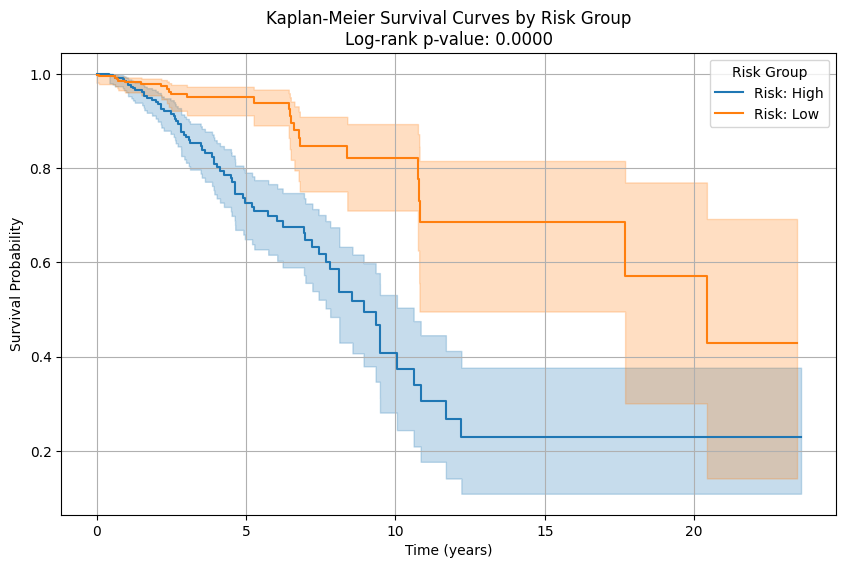

<Figure size 640x480 with 0 Axes>


Evaluating best_val data (best model)
Loaded best checkpoint


C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\289373198.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(checkpoint)


best_val_a0.0_b4_wsi+genomics/c-index: 0.6813800101471335
best_val_a0.0_b4_wsi+genomics/Loss: 107.68850708007812
best_val_a0.0_b4_wsi+genomics/TCGA_BRCA_c-index: 0.6813800101471335
best_val_a0.0_b4_wsi+genomics/TCGA_BRCA_Loss: 107.68850708007812
Log-rank test p-value: 0.02188118624319457


C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\289373198.py:46: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


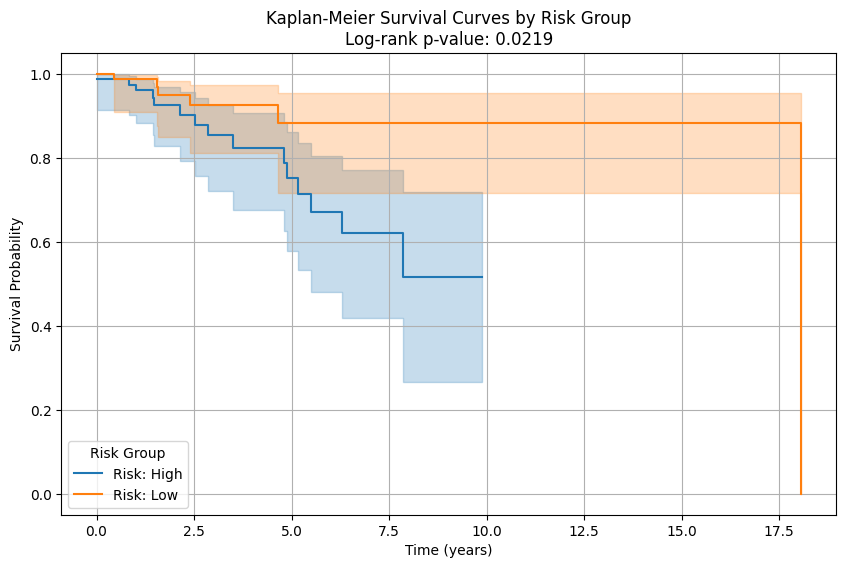

<Figure size 640x480 with 0 Axes>


Evaluating best_test data (best model)


C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\289373198.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(checkpoint)


Loaded best checkpoint
best_test_a0.0_b4_wsi+genomics/c-index: 0.6591889559965487
best_test_a0.0_b4_wsi+genomics/Loss: 125.76766204833984
best_test_a0.0_b4_wsi+genomics/TCGA_BRCA_c-index: 0.6591889559965487
best_test_a0.0_b4_wsi+genomics/TCGA_BRCA_Loss: 125.76766204833984
Log-rank test p-value: 0.013494045178841854


C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\289373198.py:46: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


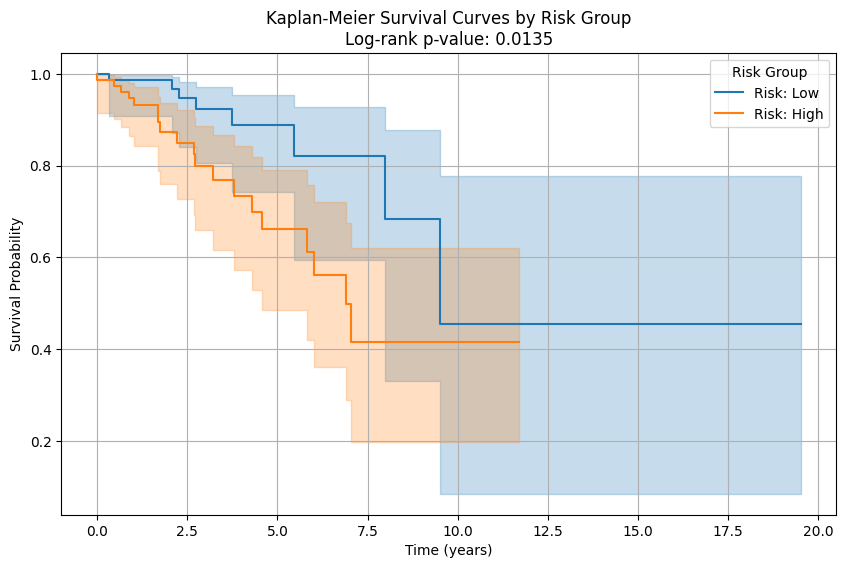

<Figure size 640x480 with 0 Axes>


Evaluating train data (last epoch)
train_a0.0_b4_wsi+genomics/c-index: 0.7056804733727811
train_a0.0_b4_wsi+genomics/Loss: 313.9541015625
train_a0.0_b4_wsi+genomics/TCGA_BRCA_c-index: 0.7056804733727811
train_a0.0_b4_wsi+genomics/TCGA_BRCA_Loss: 313.9541015625
Log-rank test p-value: 1.241679431496119e-07


C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\289373198.py:46: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


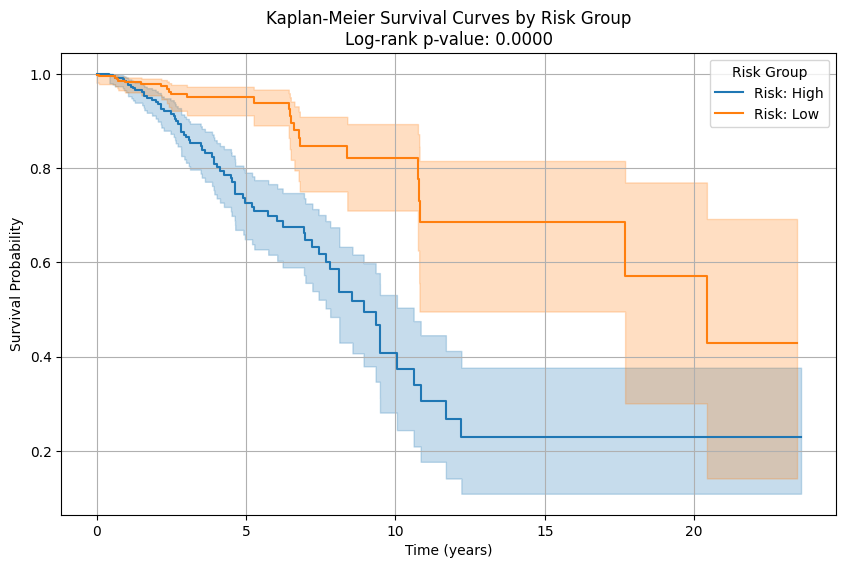

<Figure size 640x480 with 0 Axes>


Evaluating val data (last epoch)
val_a0.0_b4_wsi+genomics/c-index: 0.6813800101471335
val_a0.0_b4_wsi+genomics/Loss: 107.69197845458984
val_a0.0_b4_wsi+genomics/TCGA_BRCA_c-index: 0.6813800101471335
val_a0.0_b4_wsi+genomics/TCGA_BRCA_Loss: 107.69197845458984
Log-rank test p-value: 0.02188118624319457


C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\289373198.py:46: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


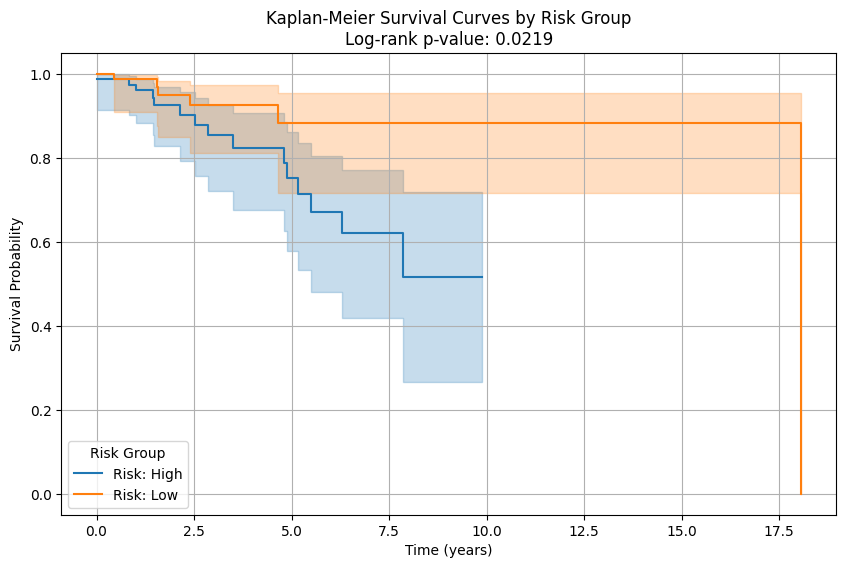

<Figure size 640x480 with 0 Axes>


Evaluating test data (last epoch)
test_a0.0_b4_wsi+genomics/c-index: 0.6591889559965487
test_a0.0_b4_wsi+genomics/Loss: 125.75360107421875
test_a0.0_b4_wsi+genomics/TCGA_BRCA_c-index: 0.6591889559965487
test_a0.0_b4_wsi+genomics/TCGA_BRCA_Loss: 125.75360107421875
Log-rank test p-value: 0.013494045178841854


C:\Users\ricca\AppData\Local\Temp\ipykernel_8960\289373198.py:46: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


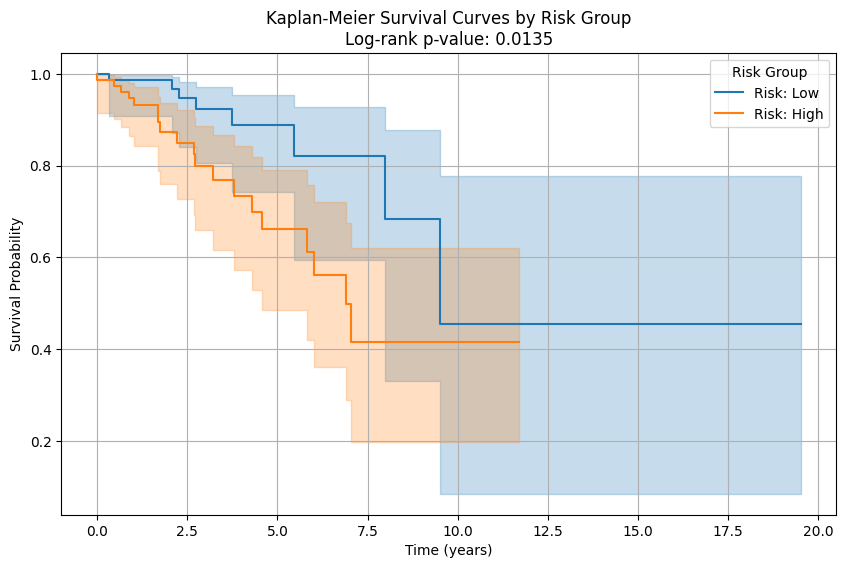

<Figure size 640x480 with 0 Axes>

In [277]:
alphas = [0.0]   #alphas = [0.0, 1.0]
modalities_list = [
    #["Genomics"],
    #["WSI"],
    ["WSI", "Genomics"],
]

# Fissiamo i bin a 4 come da esperimento
n_bins_list = [4] #per testare anche i bin puoi mettere ad esempio n_bins = [2, 4]

# aggiungere/rimuovere modelli da questa lista
models_to_test = [
    #"ABMIL_Multimodal",
    #"MCAT_Multimodal",
    "MCAT_MultimodalTopK",
    
]

# Lista per raccogliere i risultati
results_combo = []


for model_name in models_to_test:
    for alpha in alphas:
        for n_bins in n_bins_list:          # <-- iteriamo qui
            for modalities in modalities_list:
                print(f"\n{model_name} | α={alpha} | bins={n_bins} | mod={' + '.join(modalities)}")
                res = run_experiment(alpha=alpha,
                                     n_bins=n_bins,
                                     modalities=modalities,
                                     model_name=model_name)
                results_combo.append(res)


PER TESTARE BIN E ALPHA  
Obiettivo: vedere se usare o escludere i censurati ha effetti diversi in base al numero di bin


📊 Running experiment with alpha=0.0, n_bins=4

Dataset loaded with 1058 slides and 1058 patients
Train: 740, Val: 159, Test: 159

Starting epoch 1/10, LR = [0.001]


740it [00:42, 17.32it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:08, 18.65it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:06, 23.11it/s]

EPOCH 1

Epoch:                    1
LR:                       0.001
Train//c-index:           0.5042307692307693
Train//Loss:              1112.6326904296875
Train//TCGA_BRCA_c-index: 0.5042307692307693
Train//TCGA_BRCA_Loss:    1112.6326904296875
Valid//c-index:           0.4018264840182648
Valid//Loss:              240.2489776611328
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    240.2489776611328
Test//c-index:            0.5957722174288179
Test//Loss:               235.93841552734375
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     235.93841552734375



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:226: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:228: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-type

############################################ New highest_val_metric reached: 0.4018264840182648 #########################
Lowest_Validation_Loss/Valid//c-index: 0.4018264840182648
Lowest_Validation_Loss/Valid//Loss: 240.2489776611328
Lowest_Validation_Loss/Valid//TCGA_BRCA_c-index: 0.4018264840182648
Lowest_Validation_Loss/Valid//TCGA_BRCA_Loss: 240.2489776611328

Starting epoch 2/10, LR = [0.001]


740it [00:10, 70.98it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 158.33it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 176.54it/s]

EPOCH 2

Epoch:                    2
LR:                       0.001
Train//c-index:           0.5114497041420119
Train//Loss:              1114.857177734375
Train//TCGA_BRCA_c-index: 0.5114497041420119
Train//TCGA_BRCA_Loss:    1114.857177734375
Valid//c-index:           0.4018264840182648
Valid//Loss:              240.2489776611328



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")


Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    240.2489776611328
Test//c-index:            0.5957722174288179
Test//Loss:               235.93841552734375
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     235.93841552734375

Starting epoch 3/10, LR = [0.001]


740it [00:09, 76.32it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 143.74it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 183.59it/s]

EPOCH 3

Epoch:                    3
LR:                       0.001
Train//c-index:           0.5201775147928994
Train//Loss:              1113.3890380859375
Train//TCGA_BRCA_c-index: 0.5201775147928994
Train//TCGA_BRCA_Loss:    1113.3890380859375
Valid//c-index:           0.4018264840182648
Valid//Loss:              240.2489776611328
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    240.2489776611328
Test//c-index:            0.5957722174288179
Test//Loss:               235.93841552734375
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     235.93841552734375



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 4/10, LR = [0.001]


740it [00:10, 72.97it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 178.75it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 167.75it/s]

EPOCH 4

Epoch:                    4
LR:                       0.001
Train//c-index:           0.4922781065088757
Train//Loss:              1114.63720703125
Train//TCGA_BRCA_c-index: 0.4922781065088757
Train//TCGA_BRCA_Loss:    1114.63720703125
Valid//c-index:           0.4018264840182648
Valid//Loss:              240.2489776611328
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    240.2489776611328
Test//c-index:            0.5957722174288179
Test//Loss:               235.93841552734375
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     235.93841552734375



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 5/10, LR = [0.001]


740it [00:09, 77.15it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 179.75it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 179.99it/s]

EPOCH 5

Epoch:                    5
LR:                       0.001
Train//c-index:           0.5025739644970414
Train//Loss:              1115.870849609375
Train//TCGA_BRCA_c-index: 0.5025739644970414
Train//TCGA_BRCA_Loss:    1115.870849609375
Valid//c-index:           0.4018264840182648
Valid//Loss:              240.2489776611328
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    240.2489776611328
Test//c-index:            0.5957722174288179
Test//Loss:               235.93841552734375
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     235.93841552734375



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 6/10, LR = [0.001]


740it [00:09, 76.36it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 172.55it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 170.74it/s]

EPOCH 6

Epoch:                    6
LR:                       0.001
Train//c-index:           0.5044970414201183
Train//Loss:              1110.64111328125
Train//TCGA_BRCA_c-index: 0.5044970414201183
Train//TCGA_BRCA_Loss:    1110.64111328125
Valid//c-index:           0.4018264840182648
Valid//Loss:              240.2489776611328
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    240.2489776611328
Test//c-index:            0.5957722174288179
Test//Loss:               235.93841552734375
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     235.93841552734375



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 7/10, LR = [0.001]


740it [00:09, 76.63it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 186.08it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 184.04it/s]

EPOCH 7

Epoch:                    7
LR:                       0.001
Train//c-index:           0.5066568047337278
Train//Loss:              1114.23095703125
Train//TCGA_BRCA_c-index: 0.5066568047337278
Train//TCGA_BRCA_Loss:    1114.23095703125
Valid//c-index:           0.4018264840182648
Valid//Loss:              240.2489776611328
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    240.2489776611328
Test//c-index:            0.5957722174288179
Test//Loss:               235.93841552734375
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     235.93841552734375



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 8/10, LR = [0.001]


740it [00:09, 78.32it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 150.96it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 194.12it/s]

EPOCH 8

Epoch:                    8
LR:                       0.001
Train//c-index:           0.5001479289940829
Train//Loss:              1111.7725830078125
Train//TCGA_BRCA_c-index: 0.5001479289940829
Train//TCGA_BRCA_Loss:    1111.7725830078125
Valid//c-index:           0.4018264840182648
Valid//Loss:              240.2489776611328
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    240.2489776611328
Test//c-index:            0.5957722174288179
Test//Loss:               235.93841552734375
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     235.93841552734375



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\32870506.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer b

End of training phase - Patience threshold reached
Weights Restored from Lowest val_loss epoch: 1
lowest_val_loss: inf

STOPPED at epoch 8

Evaluating best_train data (best model)
Loaded best checkpoint
best_train_a0.0_b4/c-index: 0.5225147928994083
best_train_a0.0_b4/Loss: 1117.9923095703125
best_train_a0.0_b4/TCGA_BRCA_c-index: 0.5225147928994083
best_train_a0.0_b4/TCGA_BRCA_Loss: 1117.9923095703125
Log-rank test p-value: 0.27225118669693377


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


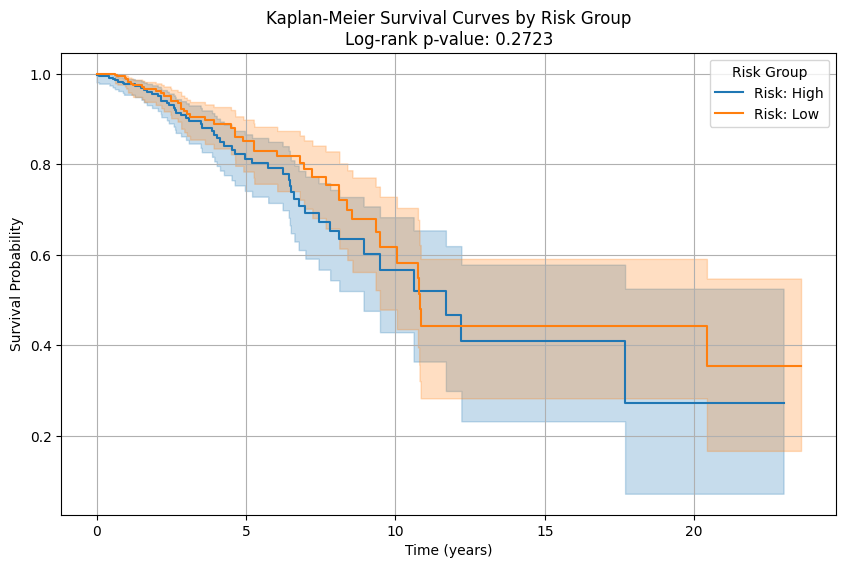


Evaluating best_val data (best model)
Loaded best checkpoint


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(checkpoint)


best_val_a0.0_b4/c-index: 0.4018264840182648
best_val_a0.0_b4/Loss: 240.2489776611328
best_val_a0.0_b4/TCGA_BRCA_c-index: 0.4018264840182648
best_val_a0.0_b4/TCGA_BRCA_Loss: 240.2489776611328
Log-rank test p-value: 0.24529478693855977


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


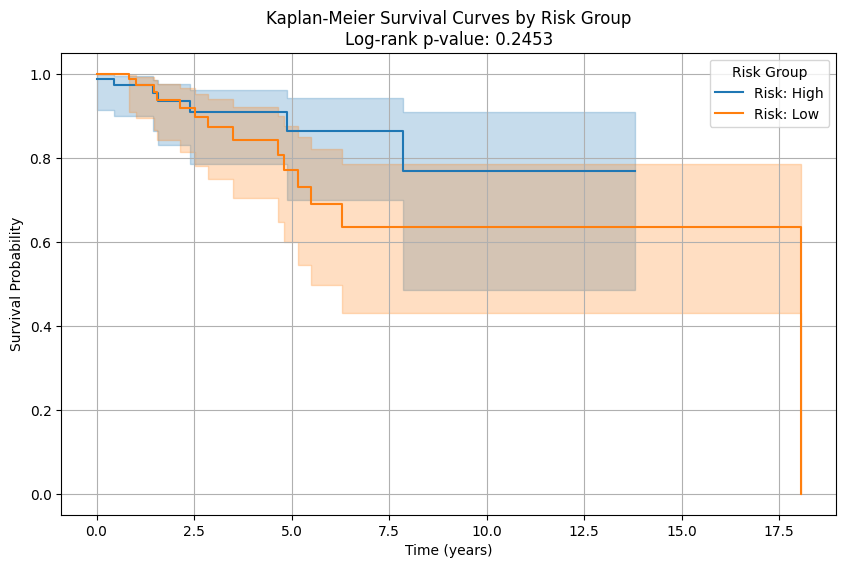

C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(checkpoint)



Evaluating best_test data (best model)
Loaded best checkpoint
best_test_a0.0_b4/c-index: 0.5957722174288179
best_test_a0.0_b4/Loss: 235.93841552734375
best_test_a0.0_b4/TCGA_BRCA_c-index: 0.5957722174288179
best_test_a0.0_b4/TCGA_BRCA_Loss: 235.93841552734375
Log-rank test p-value: 0.8928891667959268


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


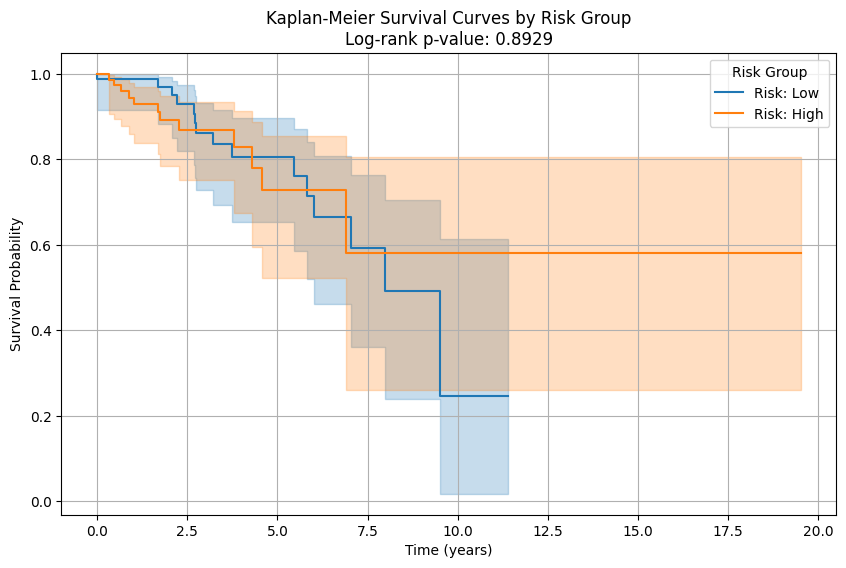


Evaluating train data (last epoch)
train_a0.0_b4/c-index: 0.5225147928994083
train_a0.0_b4/Loss: 1117.9923095703125
train_a0.0_b4/TCGA_BRCA_c-index: 0.5225147928994083
train_a0.0_b4/TCGA_BRCA_Loss: 1117.9923095703125
Log-rank test p-value: 0.27225118669693377


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


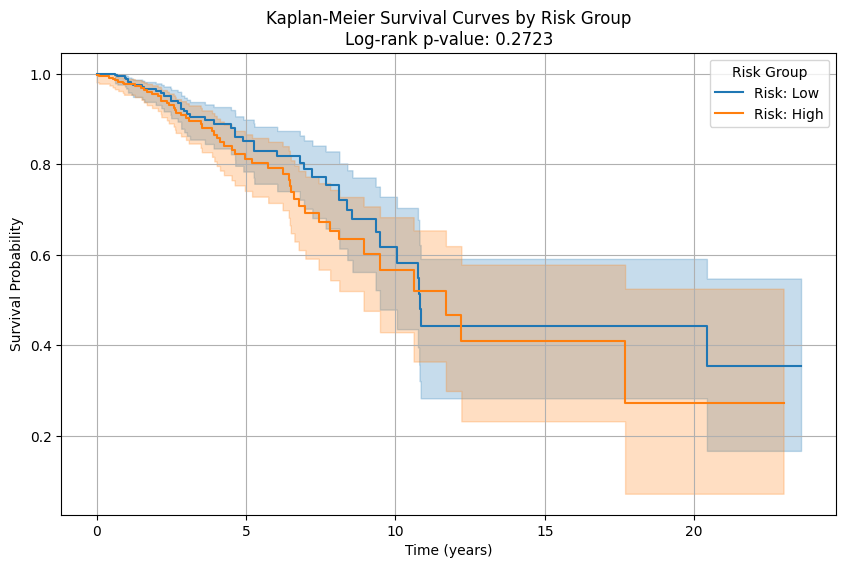


Evaluating val data (last epoch)
val_a0.0_b4/c-index: 0.4018264840182648
val_a0.0_b4/Loss: 240.2489776611328
val_a0.0_b4/TCGA_BRCA_c-index: 0.4018264840182648
val_a0.0_b4/TCGA_BRCA_Loss: 240.2489776611328
Log-rank test p-value: 0.24529478693855977


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


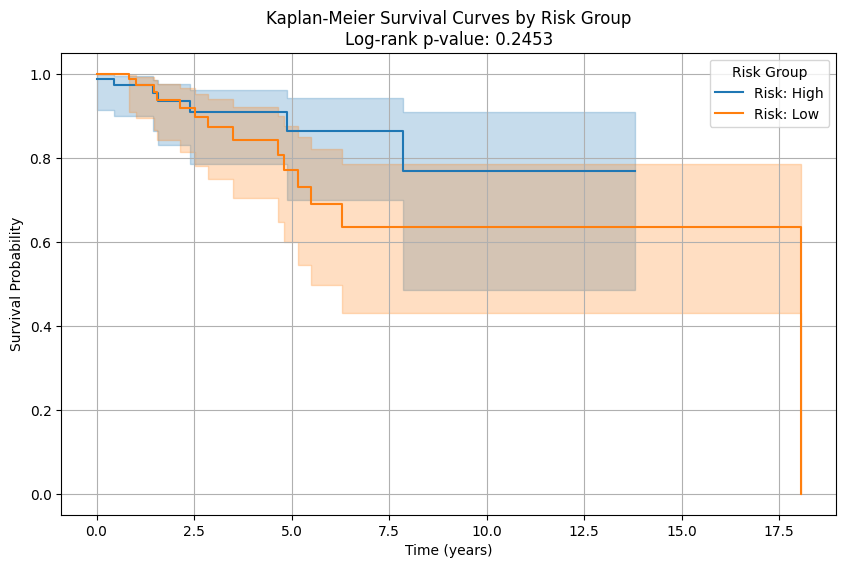


Evaluating test data (last epoch)
test_a0.0_b4/c-index: 0.5957722174288179
test_a0.0_b4/Loss: 235.93841552734375
test_a0.0_b4/TCGA_BRCA_c-index: 0.5957722174288179
test_a0.0_b4/TCGA_BRCA_Loss: 235.93841552734375
Log-rank test p-value: 0.8928891667959268


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


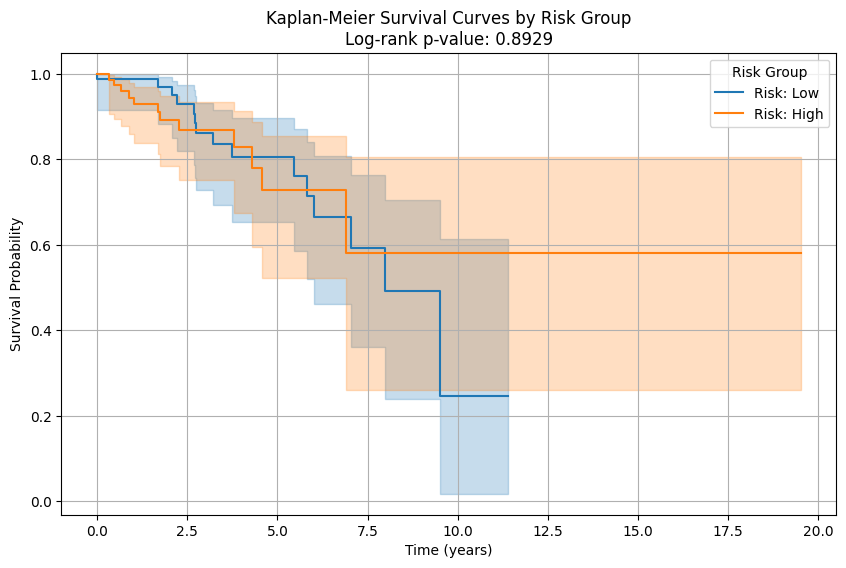


📊 Running experiment with alpha=1.0, n_bins=4

Dataset loaded with 1058 slides and 1058 patients
Train: 740, Val: 159, Test: 159

Starting epoch 1/10, LR = [0.001]


740it [00:38, 19.27it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:06, 23.25it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:06, 23.65it/s]

EPOCH 1

Epoch:                    1
LR:                       0.001
Train//c-index:           0.5042307692307693
Train//Loss:              180.364013671875
Train//TCGA_BRCA_c-index: 0.5042307692307693
Train//TCGA_BRCA_Loss:    180.364013671875
Valid//c-index:           0.4018264840182648
Valid//Loss:              30.325092315673828
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    30.325092315673828
Test//c-index:            0.5957722174288179
Test//Loss:               42.14093780517578
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     42.14093780517578



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:226: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:228: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-type

############################################ New highest_val_metric reached: 0.4018264840182648 #########################
Lowest_Validation_Loss/Valid//c-index: 0.4018264840182648
Lowest_Validation_Loss/Valid//Loss: 30.325092315673828
Lowest_Validation_Loss/Valid//TCGA_BRCA_c-index: 0.4018264840182648
Lowest_Validation_Loss/Valid//TCGA_BRCA_Loss: 30.325092315673828

Starting epoch 2/10, LR = [0.001]


740it [00:09, 74.30it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 169.73it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 194.80it/s]

EPOCH 2

Epoch:                    2



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")


LR:                       0.001
Train//c-index:           0.5114497041420119
Train//Loss:              182.04055786132812
Train//TCGA_BRCA_c-index: 0.5114497041420119
Train//TCGA_BRCA_Loss:    182.04055786132812
Valid//c-index:           0.4018264840182648
Valid//Loss:              30.325092315673828
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    30.325092315673828
Test//c-index:            0.5957722174288179
Test//Loss:               42.14093780517578
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     42.14093780517578

Starting epoch 3/10, LR = [0.001]


740it [00:09, 76.57it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 156.68it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 173.92it/s]

EPOCH 3

Epoch:                    3
LR:                       0.001
Train//c-index:           0.5201775147928994
Train//Loss:              180.96710205078125
Train//TCGA_BRCA_c-index: 0.5201775147928994
Train//TCGA_BRCA_Loss:    180.96710205078125
Valid//c-index:           0.4018264840182648
Valid//Loss:              30.325092315673828
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    30.325092315673828
Test//c-index:            0.5957722174288179
Test//Loss:               42.14093780517578
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     42.14093780517578



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 4/10, LR = [0.001]


740it [00:09, 78.82it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 166.54it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 185.44it/s]

EPOCH 4

Epoch:                    4
LR:                       0.001
Train//c-index:           0.4922781065088757
Train//Loss:              182.10488891601562
Train//TCGA_BRCA_c-index: 0.4922781065088757
Train//TCGA_BRCA_Loss:    182.10488891601562
Valid//c-index:           0.4018264840182648
Valid//Loss:              30.325092315673828
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    30.325092315673828
Test//c-index:            0.5957722174288179
Test//Loss:               42.14093780517578
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     42.14093780517578



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 5/10, LR = [0.001]


740it [00:09, 77.76it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 186.08it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 175.20it/s]

EPOCH 5

Epoch:                    5
LR:                       0.001
Train//c-index:           0.5025739644970414
Train//Loss:              180.78372192382812
Train//TCGA_BRCA_c-index: 0.5025739644970414
Train//TCGA_BRCA_Loss:    180.78372192382812
Valid//c-index:           0.4018264840182648
Valid//Loss:              30.325092315673828
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    30.325092315673828
Test//c-index:            0.5957722174288179
Test//Loss:               42.14093780517578
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     42.14093780517578



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 6/10, LR = [0.001]


740it [00:09, 74.38it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 144.72it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 168.37it/s]

EPOCH 6

Epoch:                    6
LR:                       0.001
Train//c-index:           0.5044970414201183
Train//Loss:              181.33998107910156
Train//TCGA_BRCA_c-index: 0.5044970414201183
Train//TCGA_BRCA_Loss:    181.33998107910156
Valid//c-index:           0.4018264840182648
Valid//Loss:              30.325092315673828
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    30.325092315673828
Test//c-index:            0.5957722174288179
Test//Loss:               42.14093780517578
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     42.14093780517578



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 7/10, LR = [0.001]


740it [00:09, 76.05it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 150.23it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 177.31it/s]

EPOCH 7

Epoch:                    7
LR:                       0.001
Train//c-index:           0.5066568047337278
Train//Loss:              182.06158447265625
Train//TCGA_BRCA_c-index: 0.5066568047337278
Train//TCGA_BRCA_Loss:    182.06158447265625
Valid//c-index:           0.4018264840182648
Valid//Loss:              30.325092315673828
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    30.325092315673828
Test//c-index:            0.5957722174288179
Test//Loss:               42.14093780517578
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     42.14093780517578



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 8/10, LR = [0.001]


740it [00:09, 77.16it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 180.13it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 144.10it/s]

EPOCH 8

Epoch:                    8
LR:                       0.001
Train//c-index:           0.5001479289940829
Train//Loss:              181.11570739746094
Train//TCGA_BRCA_c-index: 0.5001479289940829
Train//TCGA_BRCA_Loss:    181.11570739746094
Valid//c-index:           0.4018264840182648
Valid//Loss:              30.325092315673828
Valid//TCGA_BRCA_c-index: 0.4018264840182648
Valid//TCGA_BRCA_Loss:    30.325092315673828
Test//c-index:            0.5957722174288179
Test//Loss:               42.14093780517578
Test//TCGA_BRCA_c-index:  0.5957722174288179
Test//TCGA_BRCA_Loss:     42.14093780517578



C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\32870506.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer b

End of training phase - Patience threshold reached
Weights Restored from Lowest val_loss epoch: 1
lowest_val_loss: inf

STOPPED at epoch 8

Evaluating best_train data (best model)
Loaded best checkpoint
best_train_a1.0_b4/c-index: 0.5225147928994083
best_train_a1.0_b4/Loss: 181.14219665527344
best_train_a1.0_b4/TCGA_BRCA_c-index: 0.5225147928994083
best_train_a1.0_b4/TCGA_BRCA_Loss: 181.14219665527344
Log-rank test p-value: 0.27225118669693377


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


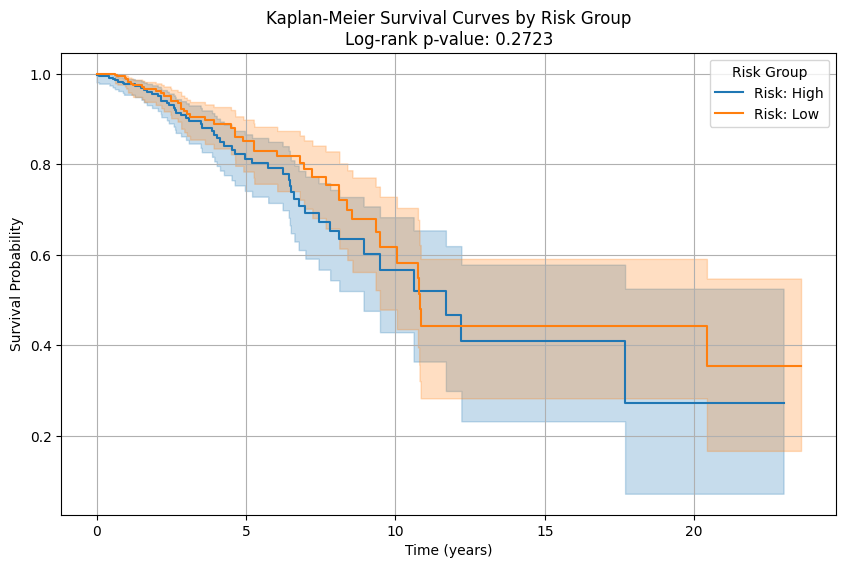


Evaluating best_val data (best model)
Loaded best checkpoint


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(checkpoint)


best_val_a1.0_b4/c-index: 0.4018264840182648
best_val_a1.0_b4/Loss: 30.325092315673828
best_val_a1.0_b4/TCGA_BRCA_c-index: 0.4018264840182648
best_val_a1.0_b4/TCGA_BRCA_Loss: 30.325092315673828
Log-rank test p-value: 0.24529478693855977


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


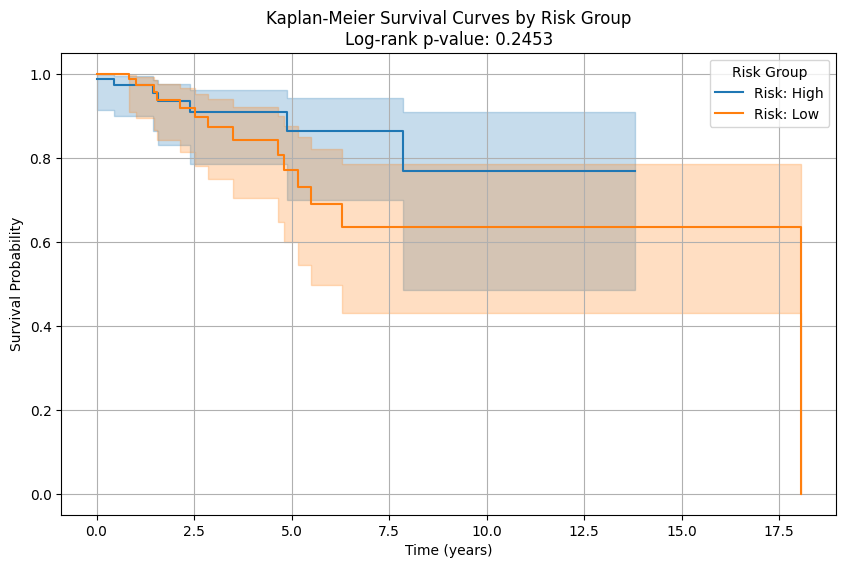


Evaluating best_test data (best model)
Loaded best checkpoint


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(checkpoint)


best_test_a1.0_b4/c-index: 0.5957722174288179
best_test_a1.0_b4/Loss: 42.14093780517578
best_test_a1.0_b4/TCGA_BRCA_c-index: 0.5957722174288179
best_test_a1.0_b4/TCGA_BRCA_Loss: 42.14093780517578
Log-rank test p-value: 0.8928891667959268


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


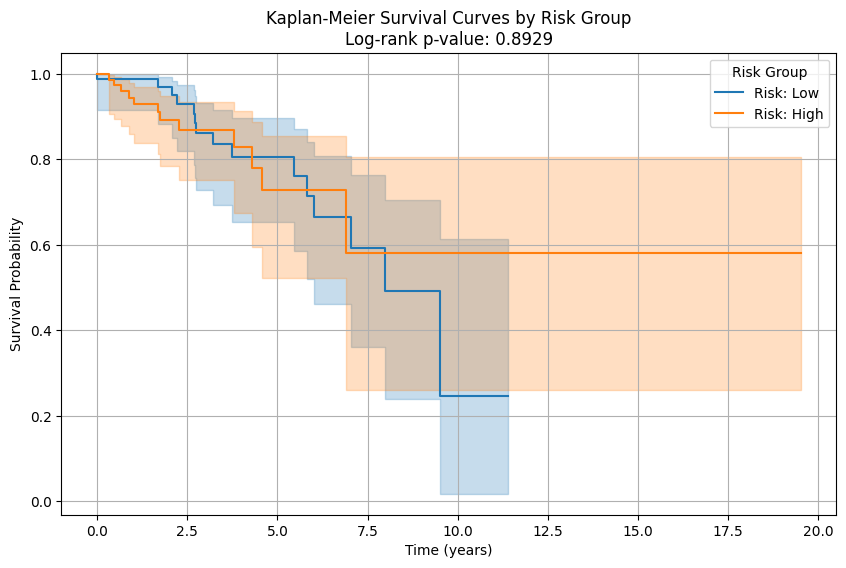


Evaluating train data (last epoch)
train_a1.0_b4/c-index: 0.5225147928994083
train_a1.0_b4/Loss: 181.1422119140625
train_a1.0_b4/TCGA_BRCA_c-index: 0.5225147928994083
train_a1.0_b4/TCGA_BRCA_Loss: 181.1422119140625
Log-rank test p-value: 0.27225118669693377


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


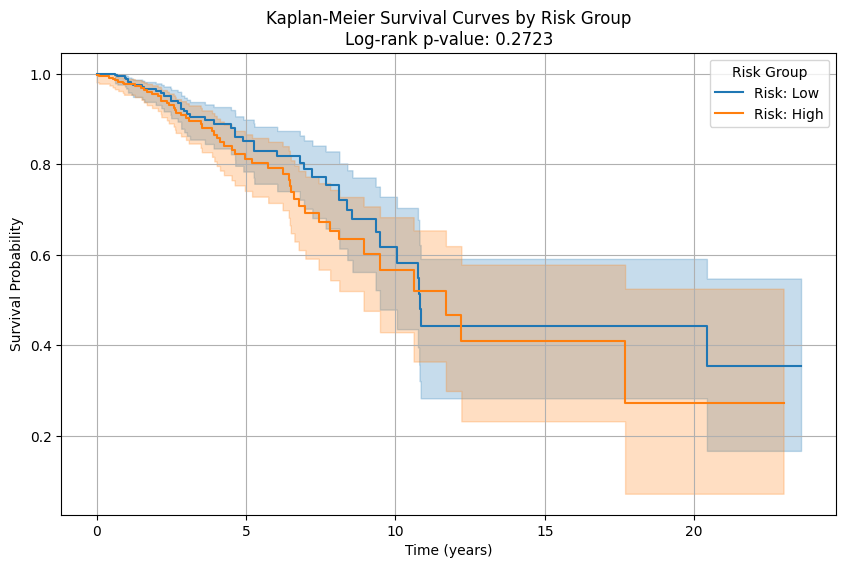


Evaluating val data (last epoch)
val_a1.0_b4/c-index: 0.4018264840182648
val_a1.0_b4/Loss: 30.325092315673828
val_a1.0_b4/TCGA_BRCA_c-index: 0.4018264840182648
val_a1.0_b4/TCGA_BRCA_Loss: 30.325092315673828
Log-rank test p-value: 0.24529478693855977


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


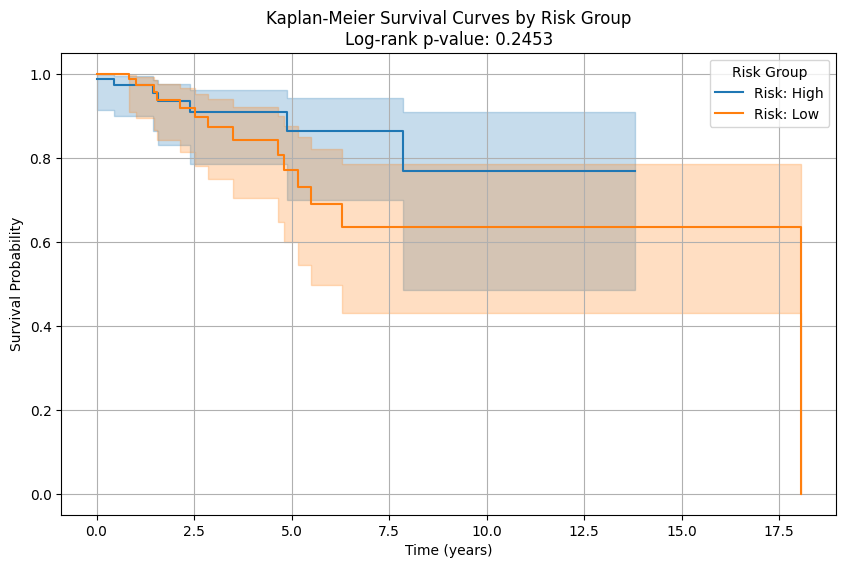


Evaluating test data (last epoch)
test_a1.0_b4/c-index: 0.5957722174288179
test_a1.0_b4/Loss: 42.14093780517578
test_a1.0_b4/TCGA_BRCA_c-index: 0.5957722174288179
test_a1.0_b4/TCGA_BRCA_Loss: 42.14093780517578
Log-rank test p-value: 0.8928891667959268


C:\Users\ricca\AppData\Local\Temp\ipykernel_24436\2752182500.py:43: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  df.to_hdf(df_path, key="df", mode="w")


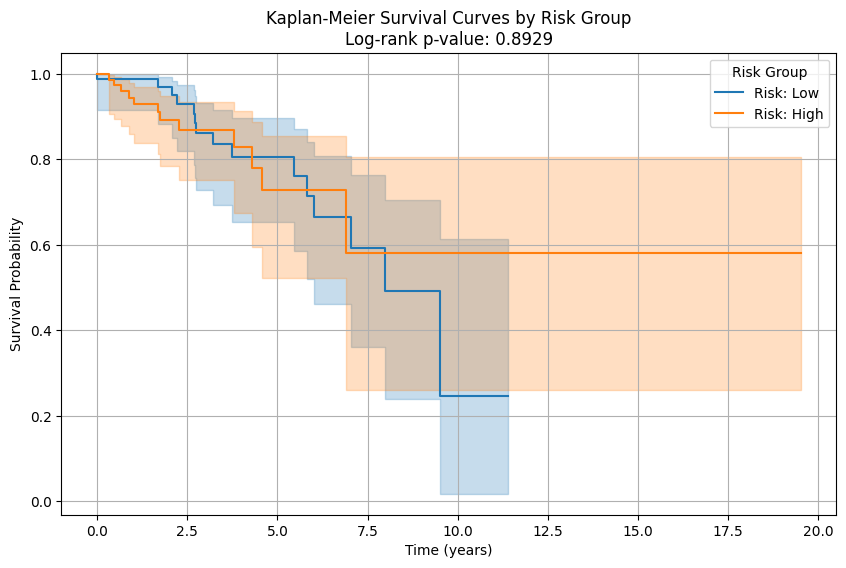

In [ ]:
# Parametri da testare. Nella cella sopra gestisci tutto, questa cella commentata serve solo
#per far vedere il vecchio codice che usavamo per testare le combinazioni di alpha e bins
'''
alphas = [0.0, 1.0]
bins_list = [4] #con 6 non va perchè Probabilmente il problema è che i tempi di sopravvivenza non hanno 
#abbastanza varianza o valori distinti tra i pazienti non censurati per poterli suddividere in 6 quantili diversi.

# Lista per raccogliere i risultati
results = []

# Loop su tutte le combinazioni
for alpha in alphas:
    for n_bins in bins_list:
        result = run_experiment(alpha=alpha, n_bins=n_bins)
        results.append(result)
'''

In [ ]:
results_df = pd.DataFrame(results_combo)
display(results_df[["model", "alpha", "n_bins",
                    "test_cindex"]])

,alpha,n_bins,train_cindex,val_cindex,test_cindex
0,0.0,4,1.00000,0.672248,0.665229
1,1.0,4,0.75432,0.498224,0.616048
